## Preprocessing and Training the Data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [9]:
# Load data with Flights, Origin and Destination Locations, Dates, Weather, Eras Tour, NFL games, etc.
df = pd.read_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\final_combined_eda.csv', low_memory=False)


Key Columns for Analysis

Date and Time Columns:

date: The date of the flight, useful for temporal analysis. day_of_week: To analyze patterns based on the day of the week. Delay Information:

flight_delay_time: Total delay time for the flight, essential for understanding delay patterns.

arrival_delay and departure_delay: Specific arrival and departure delays for deeper insights.

Delay reasons: carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay can provide insight into what might be causing delays on tour dates.

Flight Characteristics:

op_unique_carrier: Carrier information, which can help determine if certain airlines were more affected. origin_iata and dest_iata: To see if certain routes are more impacted.

Geospatial Information:

origin_latitude, origin_longitude, dest_latitude, dest_longitude: Useful for visualizing delays geographically. origin_city and dest_city: Helpful for identifying specific cities involved in the analysis.

Weather Information:

prcp, snow, snwd, tmax, tmin: Weather data can provide context on whether delays were influenced by weather conditions. Tour Indicators:

tour_date: Indicates if the flight is on a tour date.

eras_tour: If this column is set, it can signify the specific tour event impacting the flight.

Flight Count on Tour Dates vs. Non-Tour Dates:

Analyze how many flights occurred on tour dates compared to non-tour dates. Delay Patterns:

Calculate average, median delays for flights on tour dates versus non-tour dates. Visualize the distribution of delays with box plots. Impact by Airline:

Investigate if certain carriers experienced more delays on tour dates. Weather Analysis:

Examine whether weather conditions during tour dates contributed to delays. Time Series Analysis:

Look at how delays varied over time, especially around tour dates.

Investigate how Taylor Swift's Eras Tour impacts domestic Flight Delays

In [12]:
df.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

In [67]:
# Filter dates to 5/1-8/15/23 to reduce data size for modeling.
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Define the start and end dates
start_date = pd.to_datetime('2023-05-01')
end_date = pd.to_datetime('2023-08-15')

# Filter the DataFrame to keep only the rows within the specified date range
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Display the filtered DataFrame
print(df)


        day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
0            monday 2023-05-01                9e   n131ev               4888   
1            monday 2023-05-01                oo   n905ev               5331   
2            monday 2023-05-01                oo   n908ev               4761   
3            monday 2023-05-01                oo   n908ev               4761   
4            monday 2023-05-01                oo   n908ev               5529   
...             ...        ...               ...      ...                ...   
4462822     tuesday 2023-08-15                dl   n377de               2485   
4462823     tuesday 2023-08-15                dl   n377dn               1668   
4462824     tuesday 2023-08-15                dl   n377dn               1668   
4462825     tuesday 2023-08-15                dl   n377dn               1668   
4462826     tuesday 2023-08-15                dl   n377de               2485   

        origin_iata   origin_city dest_

In [69]:
# Add row showing total positive delay min
df['delay_in_min'] = (df['arr_time'] - df['crs_arr_time'])

# Set delay to zero where the delay is less than or equal to zero
df['delay_in_min'] = df['delay_in_min'].apply(lambda x: x if x > 0 else 0)

# Display the result
print(df[['arr_time', 'crs_arr_time', 'delay_in_min']].head())


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3744279224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_in_min'] = (df['arr_time'] - df['crs_arr_time'])


   arr_time  crs_arr_time  delay_in_min
0     790.0           821           0.0
1     461.0           464           0.0
2     589.0           576          13.0
3     589.0           576          13.0
4     771.0           763           8.0


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3744279224.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_in_min'] = df['delay_in_min'].apply(lambda x: x if x > 0 else 0)


In [71]:
df['eras_tour']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
4462822    NaN
4462823    NaN
4462824    NaN
4462825    NaN
4462826    NaN
Name: eras_tour, Length: 4462827, dtype: object

In [73]:
# Define tour and non-tour dates
tour_flights = df[df['eras_tour'] == 'tour_date']
non_tour_flights = df[df['eras_tour'] == '']


In [75]:


# Define tour and non-tour dates
# Define tour and non-tour flights based on values in 'eras_tour'
tour_flights = df[df['eras_tour'] == 'tour_date']

# Define non-tour flights as those with NaN in 'eras_tour'
non_tour_flights = df[df['eras_tour'].isna()]


In [77]:
# If 'eras_tour' has NaNs or other unexpected values, replace them
df['eras_tour'] = df['eras_tour'].fillna('non_tour')
df['eras_tour'].head()

C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\2303043453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eras_tour'] = df['eras_tour'].fillna('non_tour')


0    non_tour
1    non_tour
2    non_tour
3    non_tour
4    non_tour
Name: eras_tour, dtype: object

In [78]:
# Ensure 'date' column is in datetime format for both tour and non-tour flights
non_tour_flights['date'] = pd.to_datetime(non_tour_flights['date'])
tour_flights['date'] = pd.to_datetime(tour_flights['date'])

# Define the date range for filtering
max_date = '2023-08-16'
min_date = '2023-04-30'

# Filter the DataFrames to only keep rows with dates within the specified range
non_tour_flights_filtered = non_tour_flights[(non_tour_flights['date'] > min_date) & (non_tour_flights['date'] <= max_date)]
tour_flights_filtered = tour_flights[(tour_flights['date'] > min_date) & (tour_flights['date'] <= max_date)]

# Check the min and max date after filtering to ensure it's correct
print(f"Min Date (non-tour flights): {non_tour_flights_filtered['date'].min()}")
print(f"Max Date (non-tour flights): {non_tour_flights_filtered['date'].max()}")
print(f"Min Date (tour flights): {tour_flights_filtered['date'].min()}")
print(f"Max Date (tour flights): {tour_flights_filtered['date'].max()}")

# Optionally, view the first few rows of the filtered DataFrames
print(non_tour_flights_filtered.head())
print(tour_flights_filtered.head())


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\215332968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_tour_flights['date'] = pd.to_datetime(non_tour_flights['date'])
C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\215332968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tour_flights['date'] = pd.to_datetime(tour_flights['date'])


Min Date (non-tour flights): 2023-05-01 00:00:00
Max Date (non-tour flights): 2023-08-15 00:00:00
Min Date (tour flights): 2023-05-05 00:00:00
Max Date (tour flights): 2023-08-09 00:00:00
  day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
0      monday 2023-05-01                9e   n131ev               4888   
1      monday 2023-05-01                oo   n905ev               5331   
2      monday 2023-05-01                oo   n908ev               4761   
3      monday 2023-05-01                oo   n908ev               4761   
4      monday 2023-05-01                oo   n908ev               5529   

  origin_iata   origin_city dest_iata    dest_city  crs_dep_time  ...  \
0         cvg    cincinnati       msp  minneapolis           754  ...   
1         sbn    south bend       ord      chicago           460  ...   
2         psp  palm springs       lax  los angeles           524  ...   
3         psp  palm springs       lax  los angeles           524  ...   
4 

In [79]:
# Ensure the 'date' column is in datetime format (if not already)
non_tour_flights['date'] = pd.to_datetime(df['date'])
tour_flights['date'] = pd.to_datetime(df['date'])

# Define the max date for filtering
max_date = '2023-08-16'
min_date= '2023-04-30'
# Filter the DataFrame to only keep rows with dates more than than the min date
non_tour_flights = non_tour_flights[non_tour_flights['date'] > min_date]
tour_flights_filtered = tour_flights[tour_flights['date'] > min_date]

# Filter the DataFrame to only keep rows with dates less than or equal to the max date
non_tour_flights = non_tour_flights[non_tour_flights['date'] <= max_date]
tour_flights = tour_flights[tour_flights['date'] <= max_date]

# Check the min and max date after filtering to ensure it's correct
print(f"Min Date: {non_tour_flights['date'].min()}")
print(f"Max Date: {non_tour_flights['date'].max()}")
print(f"Min Date: {tour_flights['date'].min()}")
print(f"Max Date: {tour_flights['date'].max()}")

# Optionally, view the first few rows of the filtered DataFrame
print(non_tour_flights.head())
print(tour_flights.head())


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1601203605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_tour_flights['date'] = pd.to_datetime(df['date'])
C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1601203605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tour_flights['date'] = pd.to_datetime(df['date'])


Min Date: 2023-05-01 00:00:00
Max Date: 2023-08-15 00:00:00
Min Date: 2023-05-05 00:00:00
Max Date: 2023-08-09 00:00:00
  day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
0      monday 2023-05-01                9e   n131ev               4888   
1      monday 2023-05-01                oo   n905ev               5331   
2      monday 2023-05-01                oo   n908ev               4761   
3      monday 2023-05-01                oo   n908ev               4761   
4      monday 2023-05-01                oo   n908ev               5529   

  origin_iata   origin_city dest_iata    dest_city  crs_dep_time  ...  \
0         cvg    cincinnati       msp  minneapolis           754  ...   
1         sbn    south bend       ord      chicago           460  ...   
2         psp  palm springs       lax  los angeles           524  ...   
3         psp  palm springs       lax  los angeles           524  ...   
4         lax   los angeles       rdd      redding           660  ... 

In [80]:

# Count the number of flights in each category
tour_flight_count = tour_flights_filtered['op_carrier_fl_num'].count()
non_tour_flight_count = non_tour_flights_filtered['op_carrier_fl_num'].count()

# Print the results
print(f"Flights on tour dates: {tour_flight_count}")
print(f"Flights on non-tour dates: {non_tour_flight_count}")

Flights on tour dates: 32355
Flights on non-tour dates: 4430472


In [81]:
# Replace 'NA' in the 'eras_tour' column with 'non_tour' in non_tour_flights DataFrame
non_tour_flights['eras_tour'] = non_tour_flights['eras_tour'].replace('NA', 'non_tour')

# Check unique values again to confirm the update
print(non_tour_flights['eras_tour'].unique())
print(tour_flights['eras_tour'].unique())


[nan]
['tour_date']


In [82]:
tour_flights.head()

,day_of_week,date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_iata,origin_city,dest_iata,dest_city,crs_dep_time,...,delay_columns,latitude_dest,longitude_dest,elevation_dest,prcp_dest,snow_dest,snwd_dest,tmax_dest,tmin_dest,delay_in_min
163011,friday,2023-05-05,ua,n11206,394,bna,nashville,ewr,newark,1079,...,23.0,40.6925,-74.1686,599.0,NaN,NaN,NaN,NaN,NaN,23.0
163012,friday,2023-05-05,ua,n11206,394,bna,nashville,ewr,newark,1079,...,23.0,40.6925,-74.1686,599.0,NaN,NaN,NaN,NaN,NaN,23.0
163020,friday,2023-05-05,ua,n11206,394,bna,nashville,ewr,newark,1079,...,23.0,40.6925,-74.1686,599.0,NaN,NaN,NaN,NaN,NaN,23.0
163028,friday,2023-05-05,ua,n11206,394,bna,nashville,ewr,newark,1079,...,23.0,40.6925,-74.1686,599.0,NaN,NaN,NaN,NaN,NaN,23.0
163042,friday,2023-05-05,ua,n12225,740,bna,nashville,iah,houston,380,...,16.0,29.9844,-95.3414,599.0,NaN,NaN,NaN,NaN,NaN,16.0


In [83]:
# 
non_tour_flights['eras_tour'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: eras_tour, dtype: object

In [84]:
# Calculate delay time in one step using vectorized operations
df['flight_delay_category'] = (df['arr_time'] - df['crs_arr_time']).apply(
    lambda delay: 'early' if delay < -4 else ('on_time' if delay >= -4 and delay < 0 else delay) 
)

C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\693690481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flight_delay_category'] = (df['arr_time'] - df['crs_arr_time']).apply(


In [85]:
df.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

In [86]:
# Calculate delay time in one step using vectorized operations
df['delay_time_min'] = (df['arr_time'] - df['crs_arr_time']).clip(lower=0)

C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1753135552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_time_min'] = (df['arr_time'] - df['crs_arr_time']).clip(lower=0)


In [87]:
df['delay_time_min'].sort_values(ascending=False)


1838139    1439.0
1863685    1439.0
3944008    1439.0
2689015    1439.0
3849903    1439.0
            ...  
1741560       0.0
1741561       0.0
1741562       0.0
1741580       0.0
4462826       0.0
Name: delay_time_min, Length: 4462827, dtype: float64

In [88]:
tour_flights.columns = tour_flights.columns.str.strip()
non_tour_flights.columns = non_tour_flights.columns.str.strip()

print(tour_flights.columns)
print(non_tour_flights.columns)

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

In [89]:
# Check the shapes of filtered DataFrames
print(f'Tour flights shape: {tour_flights.shape}')
print(f'Non-tour flights shape: {non_tour_flights.shape}')


Tour flights shape: (32355, 79)
Non-tour flights shape: (4430472, 79)


In [90]:

# Ensure there is data before proceeding with calculations
if not tour_flights.empty and not non_tour_flights.empty:
    # Filter delays to include only values greater than 0 for both DataFrames
    tour_flights = tour_flights[tour_flights['delay_in_min'] > 0]
    non_tour_flights = non_tour_flights[non_tour_flights['delay_in_min'] > 0]

    # Calculate delay metrics
    delay_metrics = {
        'Mean of Tour vs Non-Tour Flight Count': {
            'Average Non-Tour Date Delay': non_tour_flights['delay_in_min'].mean(),
            'Average Tour Dates Delay': tour_flights['delay_in_min'].mean(),
        },
        'Median of Tour vs Non-Tour Flight Count': {
            'Median Non-Tour Dates Delay': non_tour_flights['delay_in_min'].median(),
            'Median Tour Dates Delay': tour_flights['delay_in_min'].median(),
        }
    }

    # Display delay metrics
    delay_df = pd.DataFrame(delay_metrics).T
    print(delay_df)
else:
    print("No data found for either tour or non-tour dates.")

# Manually compute the median of all flight delays (actual arrival time > scheduled arrival time)
# Filter out rows where 'flight_delay_time' is less than or equal to 0
filtered_df = df[df['delay_in_min'] > 0]

# Calculate the median of the filtered 'flight_delay_time' column
median_delay = filtered_df['delay_in_min'].median()

# Display the result
print(median_delay)


                                         Average Non-Tour Date Delay  \
Mean of Tour vs Non-Tour Flight Count                      51.534604   
Median of Tour vs Non-Tour Flight Count                          NaN   

                                         Average Tour Dates Delay  \
Mean of Tour vs Non-Tour Flight Count                   61.444308   
Median of Tour vs Non-Tour Flight Count                       NaN   

                                         Median Non-Tour Dates Delay  \
Mean of Tour vs Non-Tour Flight Count                            NaN   
Median of Tour vs Non-Tour Flight Count                         21.0   

                                         Median Tour Dates Delay  
Mean of Tour vs Non-Tour Flight Count                        NaN  
Median of Tour vs Non-Tour Flight Count                     23.0  
21.0


In [91]:
print("Tour Flights Columns:", tour_flights.columns)
print("Non-Tour Flights Columns:", non_tour_flights.columns)


Tour Flights Columns: Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig'

In [92]:
print(f"Flights on tour dates: {tour_flight_count}")
print(f"Flights on non-tour dates: {non_tour_flight_count}")


Flights on tour dates: 32355
Flights on non-tour dates: 4430472


In [93]:
# Display delay metrics
delay_df = pd.DataFrame(delay_df).T
print(delay_df)


                             Mean of Tour vs Non-Tour Flight Count  \
Average Non-Tour Date Delay                              51.534604   
Average Tour Dates Delay                                 61.444308   
Median Non-Tour Dates Delay                                    NaN   
Median Tour Dates Delay                                        NaN   

                             Median of Tour vs Non-Tour Flight Count  
Average Non-Tour Date Delay                                      NaN  
Average Tour Dates Delay                                         NaN  
Median Non-Tour Dates Delay                                     21.0  
Median Tour Dates Delay                                         23.0  


In [94]:
# Manually compute the median of all flight delays (actual arrival time > scheduled arrival time)
# Filter out rows where 'delay_in_min' is less than or equal to 0
filtered_df = df[df['delay_time_min'] > 0]

# Calculate the median of the filtered 'delay_in_min' column
median_delay = filtered_df['delay_time_min'].median()

# Display the result
print(median_delay)

21.0


In [95]:
# Manually compute the median of all flight delays (actual arrival time > scheduled arrival time)# Filter out rows where 'delay_in_min' is less than or equal to 0
filtered_df = df[df['delay_time_min'] > 0]

# Calculate the median of the filtered 'delay_in_min' column
median_delay = filtered_df['delay_time_min'].median()

# Display the result
print(median_delay)


21.0


In [96]:
# Check if 'flight_delay_time' has any non-NaN values for non-tour flights
non_tour_flights_total_delay = non_tour_flights['delay_in_min']

# Check the number of non-NaN values in non-tour flights
print(f"Non-tour flights with valid flight_delay_time: {non_tour_flights_total_delay.notna().sum()}")

# Preview the non-tour flight delays to check the values
print(non_tour_flights_total_delay.head())

Non-tour flights with valid flight_delay_time: 1764096
2    13.0
3    13.0
4     8.0
5     8.0
6     8.0
Name: delay_in_min, dtype: float64


In [97]:
# Check the shapes of filtered DataFrames
print(f'Tour flights shape: {tour_flights.shape}')
print(f'Non-tour flights shape: {non_tour_flights.shape}')

# Ensure there is data before proceeding with calculations
if not tour_flights.empty and not non_tour_flights.empty:
    # Adjust delays to be non-negative for both DataFrames
    tour_flights['delay_in_min'] = tour_flights['delay_in_min'].clip(lower=0)
    non_tour_flights['delay_in_min'] = non_tour_flights['delay_in_min'].clip(lower=0)

    # Calculate delay metrics, ensuring to drop NaN values for median calculations
    delay_metrics = {
        'Mean of Tour vs Non-Tour Dates': {
            'Average Non-Tour Date Delay': non_tour_flights['delay_in_min'].mean(),
            'Average Tour Dates Delay': tour_flights['delay_in_min'].mean(),
        },
        'Median of Tour vs Non-Tour Dates': {
            'Median Non-Tour Dates Delay': non_tour_flights['delay_in_min'].dropna().median(),
            'Median Tour Dates Delay': tour_flights['delay_in_min'].dropna().median(),
        }
    }

    # Display delay metrics
    delay_metrics_df = pd.DataFrame(delay_metrics)
    print(delay_metrics_df)
    delay_df = pd.DataFrame(delay_metrics).T
    print(delay_df)
else:
    print("No data found for either tour or non-tour dates.")


Tour flights shape: (13063, 79)
Non-tour flights shape: (1764096, 79)
                             Mean of Tour vs Non-Tour Dates  \
Average Non-Tour Date Delay                       51.534604   
Average Tour Dates Delay                          61.444308   
Median Non-Tour Dates Delay                             NaN   
Median Tour Dates Delay                                 NaN   

                             Median of Tour vs Non-Tour Dates  
Average Non-Tour Date Delay                               NaN  
Average Tour Dates Delay                                  NaN  
Median Non-Tour Dates Delay                              21.0  
Median Tour Dates Delay                                  23.0  
                                  Average Non-Tour Date Delay  \
Mean of Tour vs Non-Tour Dates                      51.534604   
Median of Tour vs Non-Tour Dates                          NaN   

                                  Average Tour Dates Delay  \
Mean of Tour vs Non-Tour Dates      

In [98]:
print(f"Missing values in 'tour_flights' delay column: {tour_flights['delay_in_min'].isna().sum()}")
print(f"Missing values in 'non_tour_flights' delay column: {non_tour_flights['delay_in_min'].isna().sum()}")


Missing values in 'tour_flights' delay column: 0
Missing values in 'non_tour_flights' delay column: 0


In [99]:
delay_metrics_df

,Mean of Tour vs Non-Tour Dates,Median of Tour vs Non-Tour Dates
Average Non-Tour Date Delay,51.534604,NaN
Average Tour Dates Delay,61.444308,NaN
Median Non-Tour Dates Delay,NaN,21.0
Median Tour Dates Delay,NaN,23.0


In [100]:
# Check the index and columns of the original delay_metrics_df
print("Index of delay_metrics_df:", delay_metrics_df.index)
print("Columns of delay_metrics_df:", delay_metrics_df.columns)


Index of delay_metrics_df: Index(['Average Non-Tour Date Delay', 'Average Tour Dates Delay',
       'Median Non-Tour Dates Delay', 'Median Tour Dates Delay'],
      dtype='object')
Columns of delay_metrics_df: Index(['Mean of Tour vs Non-Tour Dates', 'Median of Tour vs Non-Tour Dates'], dtype='object')


In [101]:
# Extract values from the delay_metrics_df based on the correct index/column names
tour_avg_delay = delay_metrics_df.loc['Average Tour Dates Delay', 'Mean of Tour vs Non-Tour Dates']
non_tour_avg_delay = delay_metrics_df.loc['Average Non-Tour Date Delay', 'Mean of Tour vs Non-Tour Dates']
tour_median_delay = delay_metrics_df.loc['Median Tour Dates Delay', 'Median of Tour vs Non-Tour Dates']
non_tour_median_delay = delay_metrics_df.loc['Median Non-Tour Dates Delay', 'Median of Tour vs Non-Tour Dates']

# Create the reshaped DataFrame
reshaped_df = pd.DataFrame({
    'Tour Date Flight Delay Time': [tour_avg_delay, tour_median_delay],
    'Non-Tour Date Flight Delay Time': [non_tour_avg_delay, non_tour_median_delay]
}, index=['Average', 'Median'])

# Display the reshaped DataFrame
print(reshaped_df)




         Tour Date Flight Delay Time  Non-Tour Date Flight Delay Time
Average                    61.444308                        51.534604
Median                     23.000000                        21.000000


In [102]:
delay_metrics_df = reshaped_df

print(delay_metrics_df)

         Tour Date Flight Delay Time  Non-Tour Date Flight Delay Time
Average                    61.444308                        51.534604
Median                     23.000000                        21.000000


In [103]:
# Extract the average delays for Tour and Non-Tour Dates from delay_metrics_df
tour_avg_delay = delay_metrics_df.loc['Average', 'Tour Date Flight Delay Time']
non_tour_avg_delay = delay_metrics_df.loc['Average', 'Non-Tour Date Flight Delay Time']

# Extract the median delays for Tour and Non-Tour Dates from delay_metrics_df
tour_median_delay = delay_metrics_df.loc['Median', 'Tour Date Flight Delay Time']
non_tour_median_delay = delay_metrics_df.loc['Median', 'Non-Tour Date Flight Delay Time']

# Check if the values were extracted correctly
print(f"Tour Avg Delay: {tour_avg_delay}")
print(f"Non-Tour Avg Delay: {non_tour_avg_delay}")
print(f"Tour Median Delay: {tour_median_delay}")
print(f"Non-Tour Median Delay: {non_tour_median_delay}")

# Construct the visualization data dictionary
visualization_data = {
    'Period': ['Tour Dates ±3 Days'],
    'Average Delay (Tour Date)': [tour_avg_delay],
    'Average Delay (Non-Tour Date)': [non_tour_avg_delay],
    'Median Delay (Tour Date)': [tour_median_delay],
    'Median Delay (Non-Tour Date)': [non_tour_median_delay]
}

# Create DataFrame for visualization
visualization_df = pd.DataFrame(visualization_data)

# Display the DataFrame
print(visualization_df)


Tour Avg Delay: 61.44430835183342
Non-Tour Avg Delay: 51.53460412585256
Tour Median Delay: 23.0
Non-Tour Median Delay: 21.0
               Period  Average Delay (Tour Date)  \
0  Tour Dates ±3 Days                  61.444308   

   Average Delay (Non-Tour Date)  Median Delay (Tour Date)  \
0                      51.534604                      23.0   

   Median Delay (Non-Tour Date)  
0                          21.0  


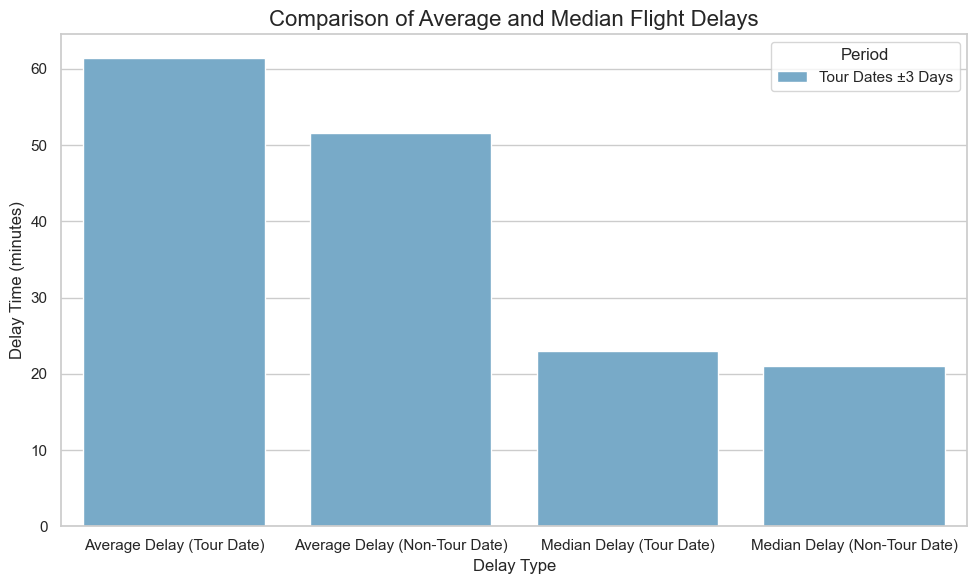

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot using matplotlib
plt.figure(figsize=(10, 6))

# Melt the DataFrame to long format for easier plotting
visualization_melted = visualization_df.melt(id_vars='Period', 
                                             value_vars=['Average Delay (Tour Date)', 'Average Delay (Non-Tour Date)', 
                                                         'Median Delay (Tour Date)', 'Median Delay (Non-Tour Date)'], 
                                             var_name='Delay Type', value_name='Delay Time')

# Plot the data
sns.barplot(x='Delay Type', y='Delay Time', hue='Period', data=visualization_melted, palette='Blues')

# Add labels and title
plt.title('Comparison of Average and Median Flight Delays', fontsize=16)
plt.xlabel('Delay Type', fontsize=12)
plt.ylabel('Delay Time (minutes)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [105]:
print(f"Data type of 'tour_flights[flight_delay_time]': {tour_flights['delay_in_min'].dtype}")
print(f"Data type of 'non_tour_flights[flight_delay_time]': {non_tour_flights['delay_in_min'].dtype}")


Data type of 'tour_flights[flight_delay_time]': float64
Data type of 'non_tour_flights[flight_delay_time]': float64


In [106]:
# Check for unique values and the distribution of delay times
print(f"Unique values in 'tour_flights[delay_in_min]': {tour_flights['delay_in_min'].unique()[:10]}")  # Show first 10 unique values
print(f"Unique values in 'non_tour_flights[delay_in_min]': {non_tour_flights['delay_in_min'].unique()[:10]}")  # Show first 10 unique values

# Check the range of values (min, max)
print(f"Range of 'tour_flights[delay_in_min]': {tour_flights['delay_in_min'].min()} to {tour_flights['delay_in_min'].max()}")
print(f"Range of 'non_tour_flights[delay_in_min]': {non_tour_flights['delay_in_min'].min()} to {non_tour_flights['delay_in_min'].max()}")


Unique values in 'tour_flights[delay_in_min]': [23. 16. 20. 29. 11. 17. 72.  5.  2. 14.]
Unique values in 'non_tour_flights[delay_in_min]': [ 13.   8.  16.   6.   3.  73.  35.  11. 127. 106.]
Range of 'tour_flights[delay_in_min]': 1.0 to 1439.0
Range of 'non_tour_flights[delay_in_min]': 1.0 to 1439.0


In [107]:

# Check if the column exists and if there are any NaN values
print(tour_flights['delay_in_min'].isnull().sum())  # Check for NaNs in tour flights
print(non_tour_flights['delay_in_min'].isnull().sum())  # Check for NaNs in non-tour flights




0
0


In [108]:
# Check the number of rows in both datasets
print(f"Tour flights: {len(tour_flights)}")
print(f"Non-tour flights: {len(non_tour_flights)}")


Tour flights: 13063
Non-tour flights: 1764096


In [109]:
# Check lengths of both datasets to ensure they are non-empty
print(f"Tour flights with delay data: {len(tour_flights)}")
print(f"Non-tour flights with delay data: {len(non_tour_flights)}")

# Check for missing values in the delay column for both tour and non-tour flights
print(f"Missing values in tour flights flight_delay_time: {tour_flights['delay_in_min'].isna().sum()}")
print(f"Missing values in non-tour flights flight_delay_time: {non_tour_flights['delay_in_min'].isna().sum()}")


Tour flights with delay data: 13063
Non-tour flights with delay data: 1764096
Missing values in tour flights flight_delay_time: 0
Missing values in non-tour flights flight_delay_time: 0


In [110]:
 non_tour_flights['delay_in_min'].head()

2    13.0
3    13.0
4     8.0
5     8.0
6     8.0
Name: delay_in_min, dtype: float64

In [111]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Define the date range for filtering
start_date = '2023-05-01'
end_date = '2023-08-16'

# Filter the DataFrame to keep rows where 'eras_tour' is not 'non_tour' OR if 'non_tour' flights are within the date range
df_filtered_eras_dates = df[~((df['eras_tour'] == 'non_tour') & 
                              ((df['date'] < start_date) | (df['date'] > end_date)))]

# Ensure the filtered DataFrame is not None and has data
if df_filtered_eras_dates is not None and not df_filtered_eras_dates.empty:
    print("Filtered DataFrame is not None and has rows.")
    print(df_filtered_eras_dates.head())  # Preview the first few rows
else:
    print("The filtered DataFrame is empty or None.")


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\2917700822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Filtered DataFrame is not None and has rows.
  day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
0      monday 2023-05-01                9e   n131ev               4888   
1      monday 2023-05-01                oo   n905ev               5331   
2      monday 2023-05-01                oo   n908ev               4761   
3      monday 2023-05-01                oo   n908ev               4761   
4      monday 2023-05-01                oo   n908ev               5529   

  origin_iata   origin_city dest_iata    dest_city  crs_dep_time  ...  \
0         cvg    cincinnati       msp  minneapolis           754  ...   
1         sbn    south bend       ord      chicago           460  ...   
2         psp  palm springs       lax  los angeles           524  ...   
3         psp  palm springs       lax  los angeles           524  ...   
4         lax   los angeles       rdd      redding           660  ...   

   longitude_dest  elevation_dest  prcp_dest  snow_dest  snwd_dest  tma

   week_of_year op_unique_carrier  eras_tour       mean  median
0            18                9e   non_tour   5.847746     0.0
1            18                aa   non_tour  15.925571     0.0
2            18                aa  tour_date  16.463768     0.0
3            18                as   non_tour  11.684969     0.0
4            18                as  tour_date  13.333333     0.0


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1461320878.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=weekly_airline_delays, x='week_of_year', y='mean', hue='eras_tour', palette='pastel', ci=None)


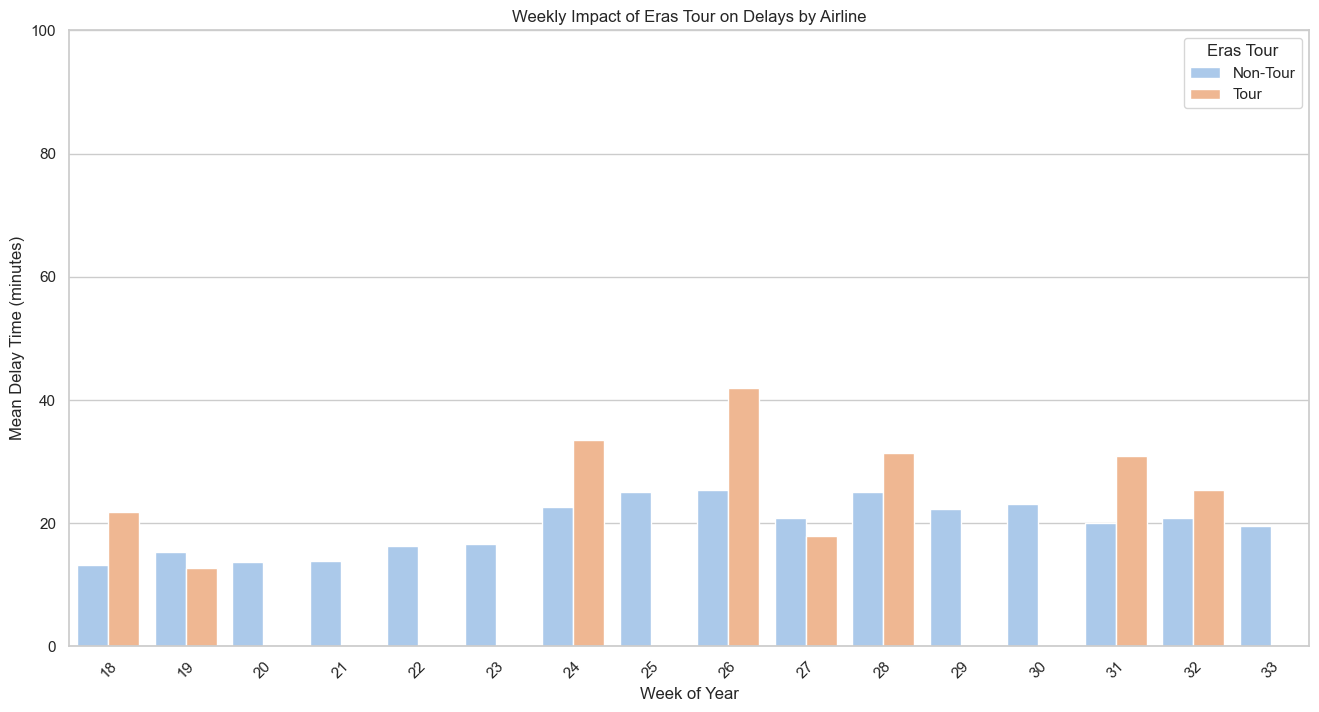

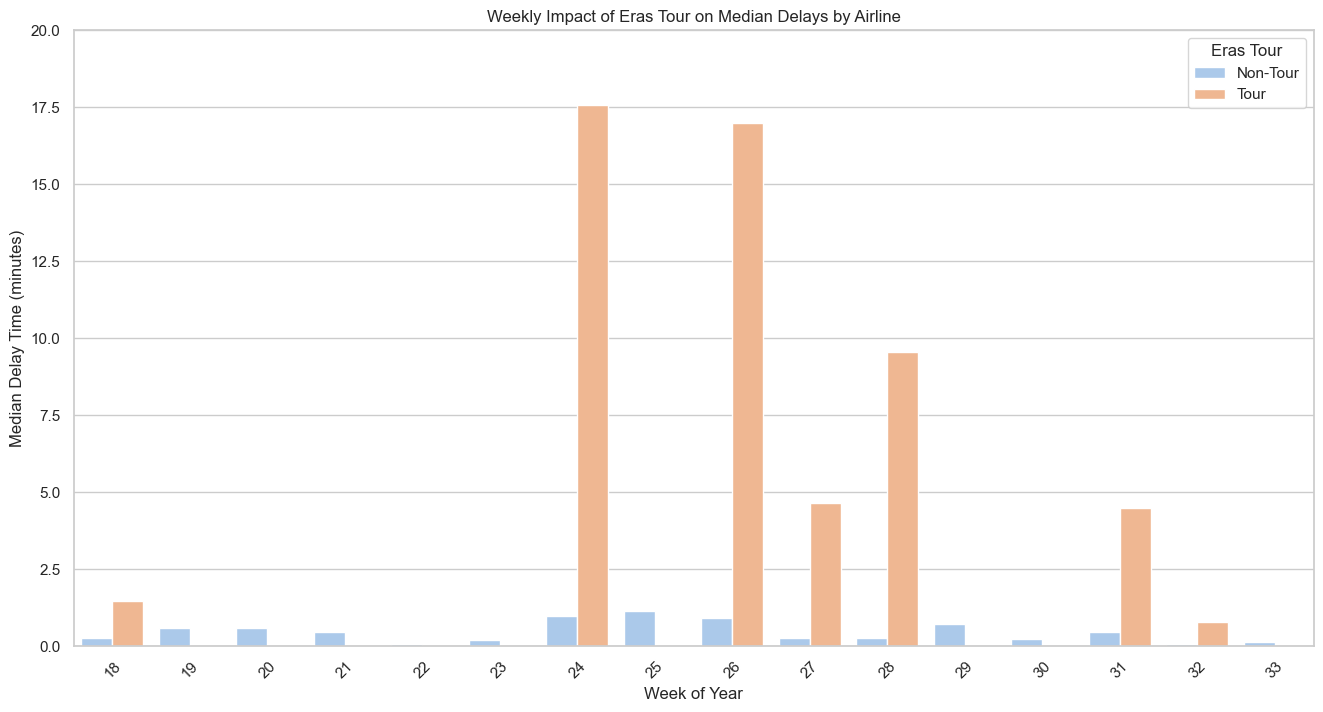

In [112]:
# Analyze impact of Eras Tour by airline
# Ensure 'flight_date' is in datetime format
df_filtered_eras_dates['date'] = pd.to_datetime(df['date'])

# Extract the week of the year from 'flight_date' and create a new column 'week_of_year'
df_filtered_eras_dates['week_of_year'] = df_filtered_eras_dates['date'].dt.isocalendar().week

# Group by week, airline, and tour status, then calculate mean and median delays
weekly_airline_delays = df_filtered_eras_dates.groupby(['week_of_year', 'op_unique_carrier', 'eras_tour'])['delay_in_min'].agg(['mean', 'median']).reset_index()

# Check the aggregated data to ensure the grouping is correct
print(weekly_airline_delays.head())

# Visualize the results
plt.figure(figsize=(16, 8))

# Create a barplot for mean delays, with hue for 'eras_tour' (Tour vs Non-Tour)
sns.barplot(data=weekly_airline_delays, x='week_of_year', y='mean', hue='eras_tour', palette='pastel', ci=None)

# Customize the plot
plt.title('Weekly Impact of Eras Tour on Delays by Airline')
plt.xlabel('Week of Year')
plt.ylabel('Mean Delay Time (minutes)')
plt.legend(title='Eras Tour', labels=['Non-Tour', 'Tour'])
plt.xticks(rotation=45)
plt.ylim(0, 100) 
plt.show()

# Visualize the median delay time as well
plt.figure(figsize=(16, 8))
sns.barplot(data=weekly_airline_delays, x='week_of_year', y='median', hue='eras_tour', palette='pastel', errorbar=None)

# Customize the plot
plt.title('Weekly Impact of Eras Tour on Median Delays by Airline')
plt.xlabel('Week of Year')
plt.ylabel('Median Delay Time (minutes)')
plt.legend(title='Eras Tour', labels=['Non-Tour', 'Tour'])
plt.xticks(rotation=45)

# Zooming in on the y-axis by setting custom limits
plt.ylim(0, 20)  # Set the maximum y-value to 100 minutes (you can adjust this)


plt.show()


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\2811477193.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weather_impact, x='eras_tour', y='mean', palette='coolwarm')


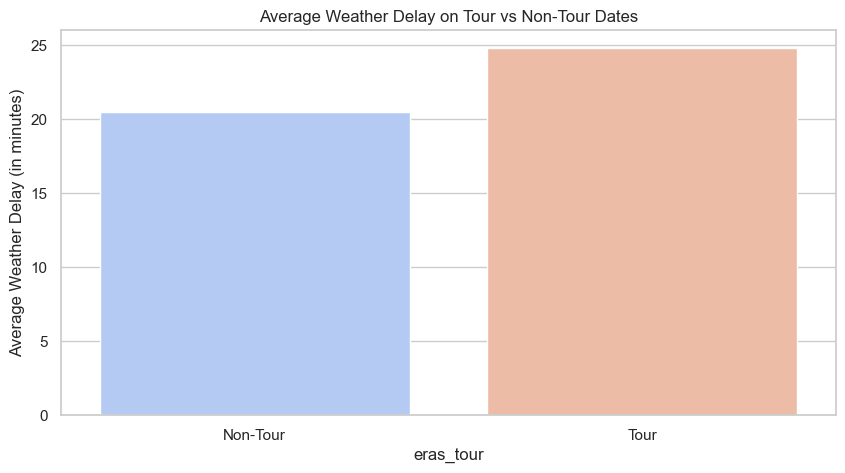

In [113]:


# Weather Analysis
# Assuming `weather_delay` indicates weather-related delays
weather_impact = df_filtered_eras_dates.groupby('eras_tour')['delay_in_min'].agg(['mean', 'median', 'sum']).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=weather_impact, x='eras_tour', y='mean', palette='coolwarm')
plt.title('Average Weather Delay on Tour vs Non-Tour Dates')
plt.ylabel('Average Weather Delay (in minutes)')
plt.xticks(ticks=[0, 1], labels=['Non-Tour', 'Tour'])
plt.show()


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1475420117.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_filtered_eras_dates, x='date', y='delay_in_min', hue='eras_tour', estimator='mean', ci=None)


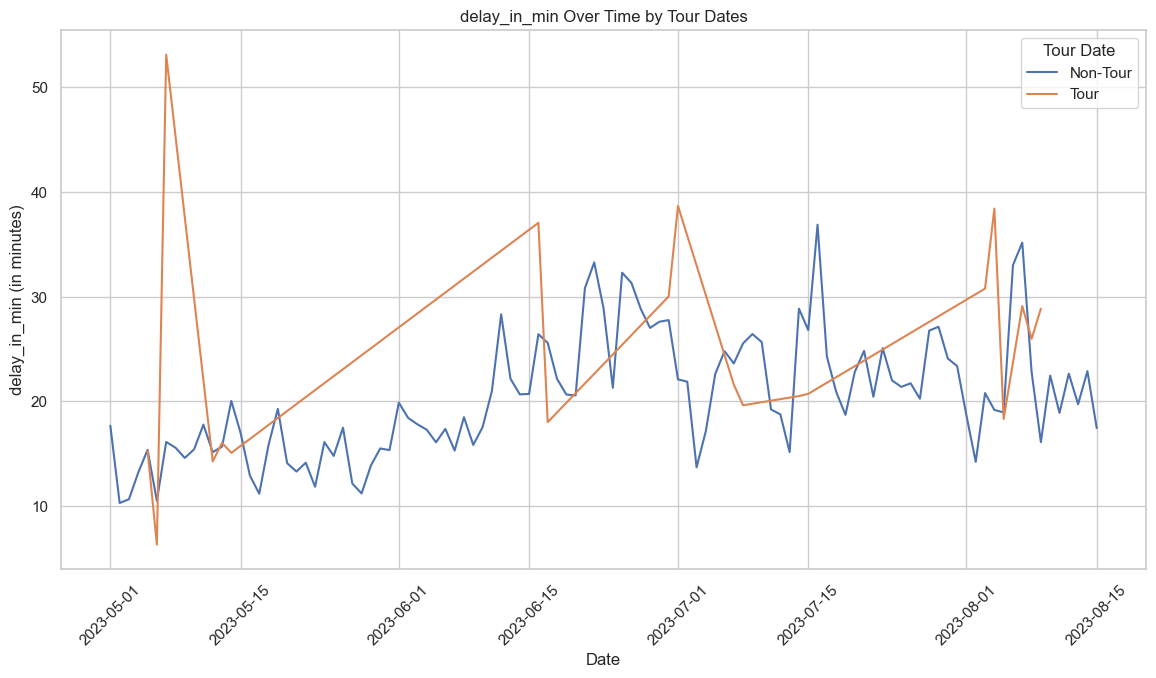

In [114]:

# Time Series Analysis

df_filtered_eras_dates['date'] = pd.to_datetime(df_filtered_eras_dates['date'])

# Plot adjusted delays over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_filtered_eras_dates, x='date', y='delay_in_min', hue='eras_tour', estimator='mean', ci=None)
plt.title('delay_in_min Over Time by Tour Dates')
plt.ylabel('delay_in_min (in minutes)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Tour Date', labels=['Non-Tour', 'Tour'])
plt.show()


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3698600072.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=weekly_airline_delays,


Missing Weeks with No 'tour_date' Entries: [20, 21, 22, 23, 25, 29, 30, 33]


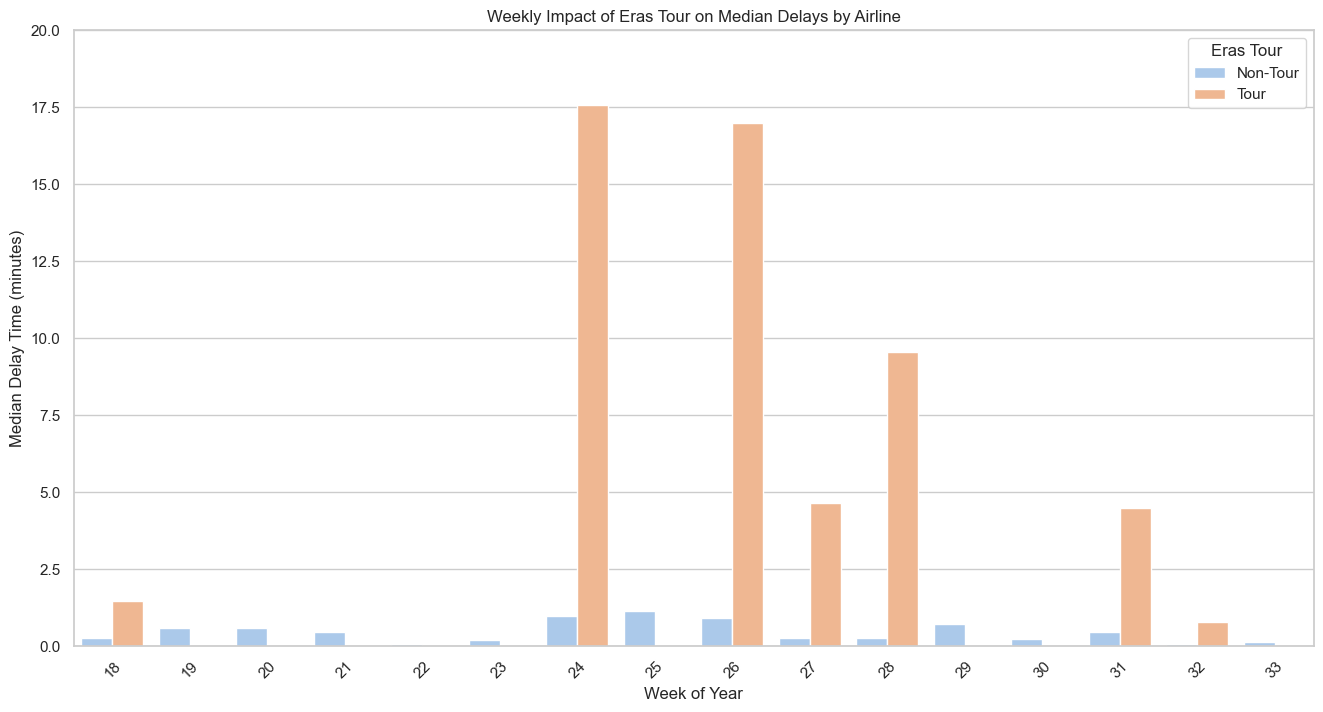

In [115]:
# Create a barplot for median delays, with hue for 'eras_tour' (Tour vs Non-Tour)
plt.figure(figsize=(16, 8))

# Create the bar plot for median delays, grouped by week_of_year and eras_tour (tour vs non-tour)
sns.barplot(data=weekly_airline_delays, 
            x='week_of_year', 
            y='median', 
            hue='eras_tour', 
            palette='pastel', 
            ci=None)

# Customize the plot title and axis labels
plt.title('Weekly Impact of Eras Tour on Median Delays by Airline')
plt.xlabel('Week of Year')
plt.ylabel('Median Delay Time (minutes)')
plt.legend(title='Eras Tour', labels=['Non-Tour', 'Tour'])
plt.xticks(rotation=45)
plt.ylim(0, 20)  # Adjust the y-axis range as needed

# Now, find the weeks with no 'tour_date' entries
# Group the data by 'week_of_year' and 'eras_tour' to check for missing weeks
weeks_with_tour = weekly_airline_delays[weekly_airline_delays['eras_tour'] == 'tour_date']['week_of_year'].unique()

# Get all the weeks in the dataset (from 1 to 52 or 53 depending on the year)
all_weeks = set(weekly_airline_delays['week_of_year'].unique())

# Determine the missing weeks (weeks with no 'tour_date')
missing_weeks = sorted(all_weeks - set(weeks_with_tour))

# Print missing weeks to check
print("Missing Weeks with No 'tour_date' Entries:", missing_weeks)

# Add annotations for weeks with no 'tour_date' data
for week in missing_weeks:
    plt.annotate(f'No Tour Data', 
                 xy=(week, 0),  # Place annotation at y=0 (or adjust based on y-limits)
                 xycoords='data', 
                 textcoords="offset points", 
                 xytext=(0, 15),  # Increase vertical offset to move annotation higher
                 ha='center', 
                 color='red', 
                 fontsize=12,  # Increase font size for visibility
                 fontweight='bold')

# Show the plot
plt.show()


In [116]:
print(tour_flights.shape)
print(non_tour_flights.shape)


(13063, 79)
(1764096, 79)


In [117]:
# Check min and max dates in the dataset
print("Min Date:", tour_flights['date'].min())
print("Max Date:", tour_flights['date'].max())

print("Min Date:", non_tour_flights['date'].min())
print("Max Date:", non_tour_flights['date'].max())

Min Date: 2023-05-05 00:00:00
Max Date: 2023-08-09 00:00:00
Min Date: 2023-05-01 00:00:00
Max Date: 2023-08-15 00:00:00


In [118]:
print(df_filtered_eras_dates['eras_tour'].unique())

['non_tour' 'tour_date']


In [119]:
# Count the number of non-tour flights based on airline 'op_carrier_fl_num'
non_tour_flight_count = non_tour_flights['op_carrier_fl_num'].count()
tour_flight_count = tour_flights['op_carrier_fl_num'].count()
# Print the result
print(f"Non-Tour Flight Count: {non_tour_flight_count}")
print(f"Tour Date Flight Count: {tour_flight_count}")

Non-Tour Flight Count: 1764096
Tour Date Flight Count: 13063


In [120]:
print(non_tour_flights.describe())
print(tour_flights.describe())


                                date  op_carrier_fl_num  crs_dep_time  \
count                        1764096       1.764096e+06  1.764096e+06   
mean   2023-06-25 19:34:26.140617728       2.139559e+03  8.759404e+02   
min              2023-05-01 00:00:00       1.000000e+00  1.000000e+00   
25%              2023-06-02 00:00:00       1.010000e+03  6.500000e+02   
50%              2023-06-26 00:00:00       1.894000e+03  9.010000e+02   
75%              2023-07-21 00:00:00       2.899000e+03  1.109000e+03   
max              2023-08-15 00:00:00       8.819000e+03  1.439000e+03   
std                              NaN       1.449681e+03  2.852282e+02   

           dep_time      taxi_out    wheels_off     wheels_on       taxi_in  \
count  1.764096e+06  1.764096e+06  1.764096e+06  1.764096e+06  1.764096e+06   
mean   8.998747e+02  1.946846e+01  1.505206e+03  1.607723e+03  9.481903e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    6.780000e+02  1.300

## Flight Delay Summary:
Non-Tour Flights:

Mean flight delay (flight_delay_time): ~50.9 minutes.
Standard deviation: ~228 minutes, indicating that while most flights are delayed by a moderate amount (mean of ~50 minutes), there are large variances and outliers (some flights are delayed by many hours).
Min: 0 minutes (indicating on-time flights).
Max: 1,438 minutes (~24 hours), which suggests some extreme delays (this could be due to cancellations or very long delays).
Median (50%): 5 minutes, which means that half of the flights in the dataset have delays of 5 minutes or less.
Eras Tour Flights:

Mean flight delay (flight_delay_time): ~42.6 minutes.
Standard deviation: ~203 minutes, which is a bit lower than the non-tour dataset, indicating less variance in the delays compared to the non-tour flights.
Min: 0 minutes (some flights were on time).
Max: 1,438 minutes (again, this could be from extreme cases like cancellations or delays due to major issues).
Median (50%): 5 minutes, which is similar to the non-tour flights, with half of the Eras Tour flights having a delay of 5 minutes or less.

Taxiing Times:
Non-Tour Flights:
Taxi-out: Mean of ~16.9 minutes, with a standard deviation of ~9.1 minutes. The maximum taxi-out time is 178 minutes, which could indicate significant delays on the ground before departure.
Taxi-in: Mean of ~8.2 minutes, with a standard deviation of ~7.1 minutes.
Eras Tour Flights:
Taxi-out: Mean of ~17.3 minutes, slightly higher than non-tour flights, but similar overall.
Taxi-in: Mean of ~8.1 minutes, very similar to non-tour flights.

Departure and Arrival Times:
Non-Tour Flights:
Scheduled Departure Time (crs_dep_time): The mean is about 824 minutes (around 13:44 or 1:44 PM). The standard deviation is ~302 minutes, indicating that departures occur at various times.
Actual Departure Time (dep_time): The mean is about 825 minutes, which is very close to the scheduled time, suggesting that departures are usually close to the scheduled times.
Scheduled Arrival Time (crs_arr_time): Mean is 909 minutes (around 3:09 PM), and the actual arrival time is very close (mean is 878 minutes or around 2:58 PM).
Eras Tour Flights:
Scheduled Departure Time: The mean is about 813 minutes (around 1:53 PM), and the standard deviation is ~313 minutes.
Actual Departure Time: The mean is about 807 minutes (around 1:47 PM), which is slightly earlier than the scheduled time.
Scheduled Arrival Time: The mean is about 890 minutes (around 2:50 PM), with the actual arrival time being very close at 873 minutes (around 2:53 PM).

Weather Variables:

Precipitation (prcp_dest):
Non-Tour Flights: Precipitation is very low (mean ~0.12 inches).
Eras Tour Flights: Precipitation is also low (mean ~0.08 inches).

These values suggest that weather conditions did not have a major impact on delays for either set of flights.
Temperature (tmax_dest and tmin_dest):
Non-Tour Flights: Mean maximum temperature ~83°F and minimum temperature ~64°F.
Eras Tour Flights: Mean maximum temperature ~87°F and minimum temperature ~66°F.
The temperatures are fairly typical for summer months, with only slight variation between the two datasets.

Interpretation:
Flight Delays: Both datasets show that flight delays, on average, are moderate (around 50 minutes for non-tour flights, and around 43 minutes for Eras Tour flights). The extreme maximum values (up to 24 hours) are likely outliers, possibly due to very rare or extreme events like cancellations or significant operational disruptions.

Taxiing Time: Both datasets show similar taxi-out times, with Eras Tour flights having a slightly higher average taxi-out time. However, the overall taxi-in times are very similar across both datasets.

Scheduled vs. Actual Times: The actual departure and arrival times for both sets of flights are very close to the scheduled times, with very minor delays on average. This suggests that, despite any delays, both the general flights and the Eras Tour flights operate on fairly predictable schedules.

Weather Impact: Both datasets show minimal impact from weather (low precipitation and typical temperatures), meaning weather disruptions likely had little effect on delays for both types of flights.

Key Conclusion:
There is not a significant difference in the delay patterns between the Eras Tour flights and non-tour flights. Both show similar mean delays (around 42-50 minutes) and comparable taxiing times, suggesting that the Eras Tour flights were not subject to abnormal delays compared to regular flights. Any large deviations in delay (such as the maximum delays) are likely due to rare or extreme events, not routine factors.

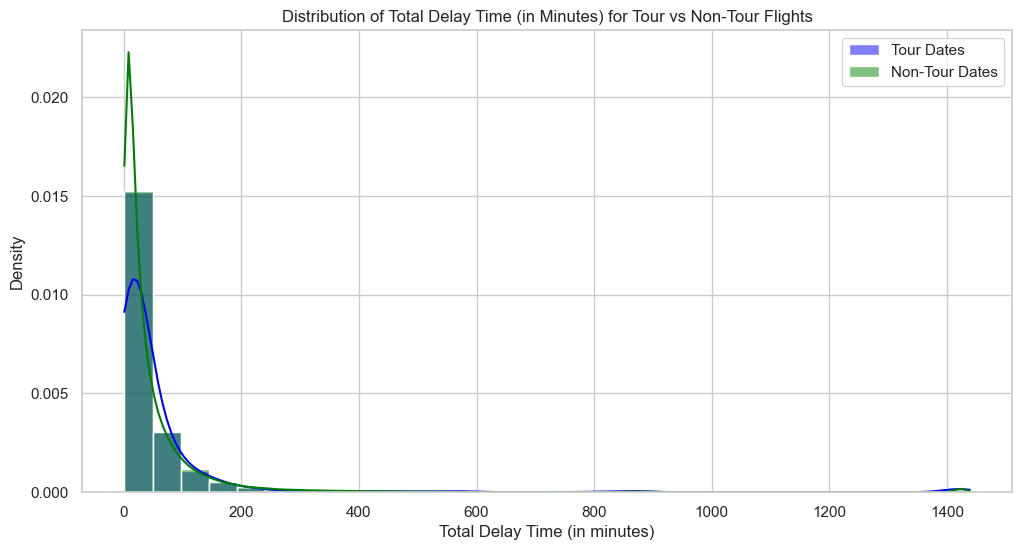

In [122]:
# Plot the distribution of delay_in_min for tour and non-tour flights
plt.figure(figsize=(12, 6))

# Plot histograms for both groups
sns.histplot(tour_flights['delay_in_min'].dropna(), bins=30, color='blue', kde=True, label='Tour Dates', stat='density')
sns.histplot(non_tour_flights['delay_in_min'].dropna(), bins=30, color='green', kde=True, label='Non-Tour Dates', stat='density')

# Add labels and title
plt.title('Distribution of Total Delay Time (in Minutes) for Tour vs Non-Tour Flights')
plt.xlabel('Total Delay Time (in minutes)')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()


In [123]:
#Check for missing values and their distribution:
missing_values = df_filtered_eras_dates.isnull().sum()
print(missing_values[missing_values > 0])


latitude_orig     3809259
longitude_orig    3809259
elevation_orig    3810351
prcp_orig         3810259
snow_orig         3919874
snwd_orig         4011342
tmax_orig         3817709
tmin_orig         3817709
tobs              4456920
iata_dest_dest    3809259
prcp_dest         3810259
snow_dest         3919874
snwd_dest         4011342
tmax_dest         3817709
tmin_dest         3817709
dtype: int64


In [124]:
df_filtered_eras_dates.columns


Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

In [125]:
# SAVE FILE
df_filtered_eras_dates = df_filtered_eras_dates.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\final_combined_data2_preprocessing2erasdates.csv')

# Last saved 11.9.12:28pm

In [126]:
# Read CSV file into DataFrame
file_path = r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\final_combined_data2_preprocessing2erasdates.csv'

# Check if the file exists
import os
if os.path.exists(file_path):
    df_filtered_eras_dates = pd.read_csv(file_path)
    print("CSV file loaded successfully.")
    print(df_filtered_eras_dates.head())  # Print the first few rows to verify the data
else:
    print(f"Error: The file {file_path} does not exist.")


CSV file loaded successfully.
   Unnamed: 0 day_of_week        date op_unique_carrier tail_num  \
0           0      monday  2023-05-01                9e   n131ev   
1           1      monday  2023-05-01                oo   n905ev   
2           2      monday  2023-05-01                oo   n908ev   
3           3      monday  2023-05-01                oo   n908ev   
4           4      monday  2023-05-01                oo   n908ev   

   op_carrier_fl_num origin_iata   origin_city dest_iata    dest_city  ...  \
0               4888         cvg    cincinnati       msp  minneapolis  ...   
1               5331         sbn    south bend       ord      chicago  ...   
2               4761         psp  palm springs       lax  los angeles  ...   
3               4761         psp  palm springs       lax  los angeles  ...   
4               5529         lax   los angeles       rdd      redding  ...   

   elevation_dest  prcp_dest  snow_dest  snwd_dest  tmax_dest  tmin_dest  \
0           896.

In [127]:
#df_filtered_eras_dates.columns

Index(['Unnamed: 0', 'day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs'

In [128]:
#df.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

In [129]:
df_filtered_eras_dates.columns

Index(['Unnamed: 0', 'day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs'

In [130]:
# Check the data type of the 'nfl_game' column
print(df_filtered_eras_dates['nfl_game'].dtype)


object


In [131]:
# Check the shape and data types
print(df_filtered_eras_dates.shape)
print(df_filtered_eras_dates.dtypes)

# Display summary statistics
print(df_filtered_eras_dates.describe(include='all'))

# Check the data type of the column
print("Data type of 'eras_tour':", df_filtered_eras_dates['eras_tour'].dtype)

# Print unique values to see what they look like
print("Unique values in 'eras_tour':", df_filtered_eras_dates['eras_tour'].unique())


(4462827, 83)
Unnamed: 0                 int64
day_of_week               object
date                      object
op_unique_carrier         object
tail_num                  object
                          ...   
tmin_dest                float64
delay_in_min             float64
flight_delay_category     object
delay_time_min           float64
week_of_year               int64
Length: 83, dtype: object
          Unnamed: 0 day_of_week        date op_unique_carrier tail_num  \
count   4.462827e+06     4462827     4462827           4462827  4462827   
unique           NaN           7         107                15     5594   
top              NaN      monday  2023-07-20                aa   n233nn   
freq             NaN      686763       44559            855217    22443   
mean    2.231413e+06         NaN         NaN               NaN      NaN   
std     1.288307e+06         NaN         NaN               NaN      NaN   
min     0.000000e+00         NaN         NaN               NaN      NaN 

In [132]:
#Check for missing values and their distribution:
missing_values = df_filtered_eras_dates.isnull().sum()
print(missing_values[missing_values > 0])

latitude_orig     3809259
longitude_orig    3809259
elevation_orig    3810351
prcp_orig         3810259
snow_orig         3919874
snwd_orig         4011342
tmax_orig         3817709
tmin_orig         3817709
tobs              4456920
iata_dest_dest    3809259
prcp_dest         3810259
snow_dest         3919874
snwd_dest         4011342
tmax_dest         3817709
tmin_dest         3817709
dtype: int64


In [133]:
# Check if 'date' is already in datetime format
if df_filtered_eras_dates['date'].dtype == 'object':
    # Convert 'date' to datetime format
    df_filtered_eras_dates['date'] = pd.to_datetime(df_filtered_eras_dates['date'])

# Filter rows where 'eras_tour' is 'tour_date'
tour_dates = df_filtered_eras_dates[df_filtered_eras_dates['eras_tour'] == 'tour_date']

# Ensure 'nfl_game' is a string column, then filter rows where 'nfl_game' contains 'game_day'
df_filtered_eras_dates['nfl_game'] = df_filtered_eras_dates['nfl_game'].astype(str)  # Convert to string if not already
game_day_df = df_filtered_eras_dates[df_filtered_eras_dates['nfl_game'].str.contains('game_day', na=False)]

# Get the unique dates for the tour dates rows
unique_tour_dates = tour_dates['date'].unique()

# Print the filtered tour dates dataframe
print(tour_dates.head())

# Print the unique tour dates
print(unique_tour_dates)




        Unnamed: 0 day_of_week       date op_unique_carrier tail_num  \
163011      163011      friday 2023-05-05                ua   n11206   
163012      163012      friday 2023-05-05                ua   n11206   
163020      163020      friday 2023-05-05                ua   n11206   
163028      163028      friday 2023-05-05                ua   n11206   
163042      163042      friday 2023-05-05                ua   n12225   

        op_carrier_fl_num origin_iata origin_city dest_iata dest_city  ...  \
163011                394         bna   nashville       ewr    newark  ...   
163012                394         bna   nashville       ewr    newark  ...   
163020                394         bna   nashville       ewr    newark  ...   
163028                394         bna   nashville       ewr    newark  ...   
163042                740         bna   nashville       iah   houston  ...   

        elevation_dest  prcp_dest  snow_dest  snwd_dest  tmax_dest  tmin_dest  \
163011           

In [134]:
# View unique values in the 'nfl_game' column
print(df['nfl_game'].unique())


['no']


In [135]:
tour_dates.columns

Index(['Unnamed: 0', 'day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs'

In [136]:

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter rows where 'eras_tour' is 'tour_date'
tour_dates = df[df['eras_tour'] == 'tour_date']['date']

# Create a list to hold the date ranges
date_ranges = []

# Loop through each tour date to create the date ranges
for tour_date in tour_dates:
    # Create a date range for ±3 days around each tour date
    start_date = tour_date - pd.DateOffset(days=3)
    end_date = tour_date + pd.DateOffset(days=3)
    date_ranges.append((start_date, end_date))

# Print the date ranges
for start, end in date_ranges:
    print(f"Start: {start.date()}, End: {end.date()}")


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3645460720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, End: 2023-05-08
Start: 2023-05-02, E

In [137]:
print(df[['arr_time', 'crs_arr_time']])

         arr_time  crs_arr_time
0           790.0           821
1           461.0           464
2           589.0           576
3           589.0           576
4           771.0           763
...           ...           ...
4462822     856.0           888
4462823     579.0           609
4462824     579.0           609
4462825     579.0           609
4462826     856.0           888

[4462827 rows x 2 columns]


In [138]:
# Find the row with the latest 'arr_time'
latest_arr_time = df[df['arr_time'] == df['arr_time'].max()]

# Find the row with the latest 'crs_arr_time'
latest_crs_arr_time = df[df['crs_arr_time'] == df['crs_arr_time'].max()]

# Display the results
print("Latest 'arr_time' row:")
print(latest_arr_time[['date', 'arr_time', 'crs_arr_time', 'delay_time_min']])

print("\nLatest 'crs_arr_time' row:")
print(latest_crs_arr_time[['date', 'arr_time', 'crs_arr_time', 'delay_time_min']])


Latest 'arr_time' row:
              date  arr_time  crs_arr_time  delay_time_min
5239    2023-05-01    1440.0          1439             1.0
5240    2023-05-01    1440.0          1439             1.0
5241    2023-05-01    1440.0          1439             1.0
18441   2023-05-01    1440.0          1410            30.0
18456   2023-05-01    1440.0          1410            30.0
...            ...       ...           ...             ...
4458636 2023-08-15    1440.0          1437             3.0
4458637 2023-08-15    1440.0          1437             3.0
4458638 2023-08-15    1440.0          1437             3.0
4458639 2023-08-15    1440.0          1437             3.0
4458640 2023-08-15    1440.0          1437             3.0

[3128 rows x 4 columns]

Latest 'crs_arr_time' row:
              date  arr_time  crs_arr_time  delay_time_min
164     2023-05-01    1432.0          1439             0.0
165     2023-05-01    1432.0          1439             0.0
171     2023-05-01    1432.0          1

In [139]:
df.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

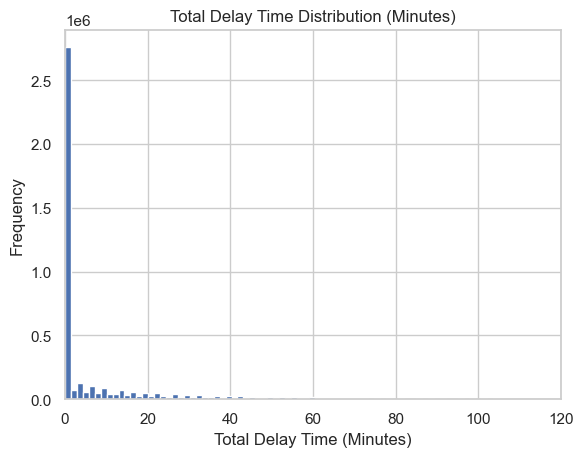

In [140]:
df['delay_time_min'].hist(bins=1000)
plt.title('Total Delay Time Distribution (Minutes)')
plt.xlabel('Total Delay Time (Minutes)' )
plt.ylabel('Frequency')

# Set x-axis limits to zoom in (adjust values as needed)
plt.xlim(0, 120)  # Change these values based on data distribution

plt.show()


In [141]:
df.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'cancelled',
       'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'municipality',
       'scheduled_service', 'unique_id', 'id', 'length_ft', 'width_ft',
       'surface', 'lighted', 'closed', 'le_ident', 'le_displaced_threshold_ft',
       'he_ident', 'he_displaced_threshold_ft', 'latitude_orig',
       'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig',
       'snwd_orig', 'tmax_orig', 'tmin_orig', 'tobs', 'iata_dest_d

C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\198758177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['date'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\198758177.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='delay_time_min', data=avg_delay_by_day, palette='viridis')


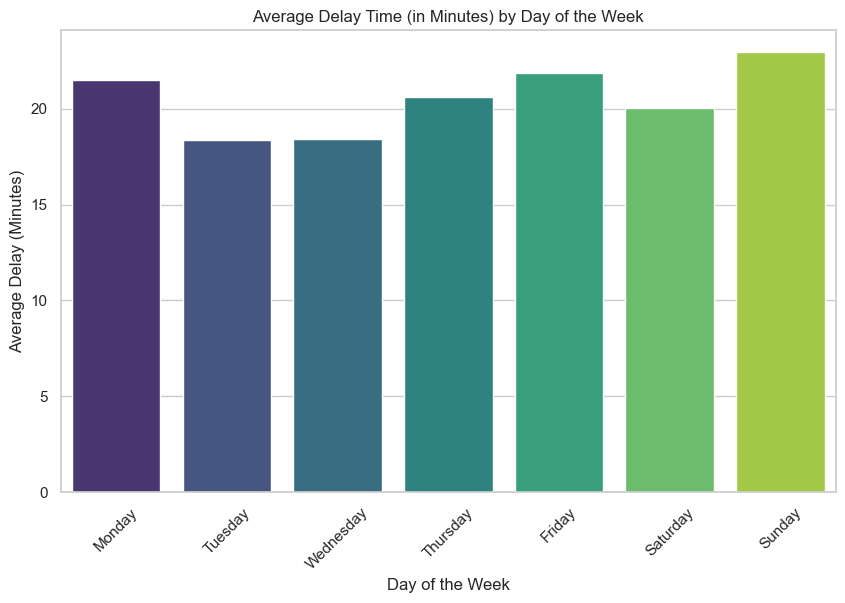

In [142]:
# Assuming 'date' is in datetime format
df['day_of_week'] = df['date'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)

# Group by day of the week and calculate the average delay in minutes
avg_delay_by_day = df.groupby('day_of_week')['delay_time_min'].mean().reset_index()

# Map the day_of_week numbers to actual day names
avg_delay_by_day['day_name'] = avg_delay_by_day['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Sort by day_name to display in order
avg_delay_by_day = avg_delay_by_day.sort_values('day_of_week')

# Plot the average delay by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='delay_time_min', data=avg_delay_by_day, palette='viridis')
plt.title('Average Delay Time (in Minutes) by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.show()


In [143]:
# Create a new column to indicate if a flight is within the ±3 days of tour dates
# Generate the ±3 day window for each tour date and update the set

# Filter the rows where 'eras_tour' is 'tour_date'
tour_dates = df[df['eras_tour'] == 'tour_date']

# Create a set of the 'date' column (tour dates)
all_tour_dates = set(tour_dates['date'])

# List to collect the new dates
new_dates = []

# Generate the ±3 day window for each tour date
for tour_date in all_tour_dates:
    start_date = tour_date - pd.Timedelta(days=3)
    end_date = tour_date + pd.Timedelta(days=3)
    new_dates.extend(pd.date_range(start_date, end_date).to_list())  # Add to the new_dates list

# Update the set with the new dates after the loop
all_tour_dates.update(new_dates)

# Check if each 'date' in df is within the ±3 days of any tour date
df['is_tour_window'] = df['date'].isin(all_tour_dates)

# Filter and display rows where 'is_tour_window' is True
tour_window_flights = df[df['is_tour_window']]

# Show the results
print(tour_window_flights)


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\251593417.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_tour_window'] = df['date'].isin(all_tour_dates)


         day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
41827              1 2023-05-02                ua   n17753                533   
41828              1 2023-05-02                ua   n18223               2288   
41829              1 2023-05-02                ua   n18223               2288   
41830              1 2023-05-02                ua   n18223                422   
41831              1 2023-05-02                ua   n18223                422   
...              ...        ...               ...      ...                ...   
4333918            5 2023-08-12                dl   n539us               2301   
4333919            5 2023-08-12                dl   n539us               2301   
4333920            5 2023-08-12                dl   n539us               2301   
4333921            5 2023-08-12                dl   n539dn               2679   
4333922            5 2023-08-12                dl   n539us                735   

        origin_iata  origin

In [144]:
# Step 2: Convert boolean to int (1 for True, 0 for False)
df['is_tour_window'] = df['is_tour_window'].astype(int)

C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\1223898697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_tour_window'] = df['is_tour_window'].astype(int)


In [145]:
# List of columns you want to process
columns_to_fill = [
    'latitude_orig', 'longitude_orig', 'elevation_orig', 'prcp_orig', 'snow_orig', 
    'snwd_orig', 'tmax_orig', 'tmin_orig', 'prcp_dest', 
    'snow_dest', 'snwd_dest', 'tmax_dest', 'tmin_dest'
]

# Loop through the specified columns and fill NaNs with the median, or 0 if the median is NaN
for col in columns_to_fill:
    # Calculate the median for the column
    median_value = df[col].median()
    
    # If the median is NaN, use 0; otherwise, use the median
    if pd.isna(median_value):
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna(median_value)

# Display the updated DataFrame (optional)
print(df[columns_to_fill].head())


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3088525295.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(median_value)


   latitude_orig  longitude_orig  elevation_orig  prcp_orig  snow_orig  \
0          38.75          -81.76            13.0        0.0        0.0   
1          38.75          -81.76            13.0        0.0        0.0   
2          38.75          -81.76            13.0        0.0        0.0   
3          38.75          -81.76            13.0        0.0        0.0   
4          38.75          -81.76            13.0        0.0        0.0   

   snwd_orig  tmax_orig  tmin_orig  prcp_dest  snow_dest  snwd_dest  \
0        0.0       84.0       66.0        0.0        0.0        0.0   
1        0.0       84.0       66.0        0.0        0.0        0.0   
2        0.0       84.0       66.0        0.0        0.0        0.0   
3        0.0       84.0       66.0        0.0        0.0        0.0   
4        0.0       84.0       66.0        0.0        0.0        0.0   

   tmax_dest  tmin_dest  
0       84.0       66.0  
1       84.0       66.0  
2       84.0       66.0  
3       84.0       66.0 

In [146]:
# Set pandas to display all columns (no truncation)
pd.set_option('display.max_columns', None)  # No limit on columns displayed
pd.set_option('display.width', None)        # Disable line wrapping
pd.set_option('display.max_rows', None)     # No limit on rows displayed (be careful if the dataset is large)

# Count NaN values in each column
nan_count = df.isna().sum()

# Display the count of NaNs for each column
print(nan_count)


day_of_week                        0
date                               0
op_unique_carrier                  0
tail_num                           0
op_carrier_fl_num                  0
origin_iata                        0
origin_city                        0
dest_iata                          0
dest_city                          0
crs_dep_time                       0
dep_time                           0
taxi_out                           0
wheels_off                         0
wheels_on                          0
taxi_in                            0
crs_arr_time                       0
arr_time                           0
cancelled                          0
diverted                           0
crs_elapsed_time                   0
actual_elapsed_time                0
air_time                           0
flights                            0
distance                           0
carrier_delay                      0
weather_delay                      0
nas_delay                          0
s

In [147]:
df['date'] = pd.to_datetime(df['date'])  # Convert 'date' to datetime if it's not already


C:\Users\hopeh\AppData\Local\Temp\ipykernel_1348\3623730720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Convert 'date' to datetime if it's not already


In [154]:
# Drop columns
df = df.drop(columns=['le_ident', 'le_displaced_threshold_ft', 'he_ident', 'he_displaced_threshold_ft'])

# Display the updated DataFrame
print(df.head())

   day_of_week       date op_unique_carrier tail_num  op_carrier_fl_num  \
0            0 2023-05-01                9e   n131ev               4888   
1            0 2023-05-01                oo   n905ev               5331   
2            0 2023-05-01                oo   n908ev               4761   
3            0 2023-05-01                oo   n908ev               4761   
4            0 2023-05-01                oo   n908ev               5529   

  origin_iata   origin_city dest_iata    dest_city  crs_dep_time  dep_time  \
0         cvg    cincinnati       msp  minneapolis           754     745.0   
1         sbn    south bend       ord      chicago           460     454.0   
2         psp  palm springs       lax  los angeles           524     516.0   
3         psp  palm springs       lax  los angeles           524     516.0   
4         lax   los angeles       rdd      redding           660     652.0   

   taxi_out  wheels_off  wheels_on  taxi_in  crs_arr_time  arr_time  \
0      13

In [11]:
# Set pandas to display all columns (no truncation)
pd.set_option('display.max_columns', None)  # No limit on columns displayed
pd.set_option('display.width', None)        # Disable line wrapping
pd.set_option('display.max_rows', None)

In [13]:
# Calculate the percentage of zeros in each column
zero_percentage = (df == 0).mean() * 100

# Display the result
print(zero_percentage)

Unnamed: 0                 0.000022
day_of_week               15.388519
date                       0.000000
op_unique_carrier          0.000000
tail_num                   0.000000
op_carrier_fl_num          0.000000
origin_iata                0.000000
origin_city                0.000000
dest_iata                  0.000000
dest_city                  0.000000
crs_dep_time               0.000000
dep_time                   0.000000
taxi_out                   0.000000
wheels_off                 0.000000
wheels_on                  0.000000
taxi_in                    0.000000
crs_arr_time               0.000000
arr_time                   0.000000
cancelled                 98.420710
diverted                  99.677895
crs_elapsed_time           0.000000
actual_elapsed_time        0.000000
air_time                   0.000000
flights                    0.000000
distance                   0.000000
carrier_delay             84.596983
weather_delay             97.952262
nas_delay                 88

In [19]:
# Find columns with 84% or more zeros
columns_to_drop = zero_percentage[zero_percentage >= 84].index

In [23]:
# Drop those columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)


In [29]:
# Display the cleaned DataFrame
print(df_cleaned.columns)

Index(['Unnamed: 0', 'day_of_week', 'date', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_iata', 'origin_city', 'dest_iata',
       'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'origin_state', 'dest_state', 'origin_latitude', 'origin_longitude',
       'dest_latitude', 'dest_longitude', 'type_of_airport', 'elevation_ft',
       'municipality', 'scheduled_service', 'unique_id', 'id', 'length_ft',
       'width_ft', 'surface', 'lighted', 'latitude_orig', 'longitude_orig',
       'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator',
       'airport_indicator', 'total_delay_time', 'is_weekend', 'arrival_delay',
       'departure_delay', 'airline_name', 'eras_tour', 'nfl_game',
       'delay_columns', 'latitude_dest', 'longitude_dest', 'elevation_dest',
       'tmax_dest', 'tmin_dest', '

In [41]:
# Count NaN values in each column
nan_count = df_cleaned.isna().sum()

In [43]:
# Display the count of NaNs for each column
print(nan_count)

Unnamed: 0               0
day_of_week              0
date                     0
op_unique_carrier        0
tail_num                 0
op_carrier_fl_num        0
origin_iata              0
origin_city              0
dest_iata                0
dest_city                0
crs_dep_time             0
dep_time                 0
taxi_out                 0
wheels_off               0
wheels_on                0
taxi_in                  0
crs_arr_time             0
arr_time                 0
crs_elapsed_time         0
actual_elapsed_time      0
air_time                 0
flights                  0
distance                 0
origin_state             0
dest_state               0
origin_latitude          0
origin_longitude         0
dest_latitude            0
dest_longitude           0
type_of_airport          0
elevation_ft             0
municipality             0
scheduled_service        0
unique_id                0
id                       0
length_ft                0
width_ft                 0
s

In [45]:
df.shape

(4462827, 77)

In [59]:
df_cleaned.shape

(4462827, 59)

In [57]:
df_cleaned = df_cleaned.drop(columns=['municipality', 'scheduled_service', 'unique_id', 'id'])


In [92]:
df_cleaned = df_cleaned.drop(columns=['tail_num'])

In [103]:
df_cleaned = df_cleaned.drop(columns=['eras_tour'])

In [104]:
df_cleaned = df_cleaned.drop(columns=['is_tour_window'])

In [81]:
# Calculate the percentage of zero values in each row
zero_percentage = (df == 0).mean(axis=1) * 100

# Display rows with more than 25% zero values
rows_25_or_more_zeros = df[zero_percentage >= 25]

# Display rows with more than 50% zero values
rows_50_or_more_zeros = df[zero_percentage >= 50]

# Display rows with more than 60% zero values
rows_60_or_more_zeros = df[zero_percentage >= 60]

In [86]:
print("\nRows with 60% or more zero values:")
print(rows_60_or_more_zeros)


Rows with 60% or more zero values:
Empty DataFrame
Columns: [Unnamed: 0, day_of_week, date, op_unique_carrier, tail_num, op_carrier_fl_num, origin_iata, origin_city, dest_iata, dest_city, crs_dep_time, dep_time, taxi_out, wheels_off, wheels_on, taxi_in, crs_arr_time, arr_time, cancelled, diverted, crs_elapsed_time, actual_elapsed_time, air_time, flights, distance, carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay, origin_state, dest_state, origin_latitude, origin_longitude, dest_latitude, dest_longitude, type_of_airport, elevation_ft, municipality, scheduled_service, unique_id, id, length_ft, width_ft, surface, lighted, closed, latitude_orig, longitude_orig, elevation_orig, prcp_orig, snow_orig, snwd_orig, tmax_orig, tmin_orig, weather_indicator, airport_indicator, total_delay_time, is_weekend, arrival_delay, departure_delay, airline_name, eras_tour, nfl_game, delay_columns, latitude_dest, longitude_dest, elevation_dest, prcp_dest, snow_dest, snwd_dest, tmax

In [111]:
# Convert the 'date' column to datetime format (if it's not already)
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# Filter rows for March 2024 to get a smaller sample of the data to work with 
df_july_2023 = df_cleaned[(df_cleaned['date'].dt.year == 2023) & (df_cleaned['date'].dt.month == 7)]

In [119]:
df_july_2023.head()

,Unnamed: 0,day_of_week,date,op_unique_carrier,op_carrier_fl_num,origin_iata,origin_city,dest_iata,dest_city,crs_dep_time,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,origin_state,dest_state,origin_latitude,origin_longitude,dest_latitude,dest_longitude,type_of_airport,elevation_ft,length_ft,width_ft,surface,lighted,latitude_orig,longitude_orig,elevation_orig,tmax_orig,tmin_orig,weather_indicator,total_delay_time,is_weekend,arrival_delay,departure_delay,airline_name,nfl_game,delay_columns,latitude_dest,longitude_dest,elevation_dest,tmax_dest,tmin_dest,delay_in_min,flight_delay_category,delay_time_min
2504485,2504485,5,2023-07-01,oo,4645,bih,bishop,sfo,san francisco,927,917.0,6.0,1523.0,1603.0,5.0,1004,968.0,77.0,51.0,40.0,1.0,221.0,ca,ca,37.3731,-118.364,37.6190,-122.3750,medium_airport,4124.0,5566.0,100.0,asp,1,38.75,-81.76,13.0,84.0,66.0,0.0,-26.0,1,-36.0,-10.0,skywest airlines,no,0.0,37.6190,-122.3750,4124.0,84.0,66.0,0.0,early,0.0
2504486,2504486,5,2023-07-01,oo,4645,bih,bishop,sfo,san francisco,927,917.0,6.0,1523.0,1603.0,5.0,1004,968.0,77.0,51.0,40.0,1.0,221.0,ca,ca,37.3731,-118.364,37.6190,-122.3750,medium_airport,4124.0,5600.0,100.0,asp,1,38.75,-81.76,13.0,84.0,66.0,0.0,-26.0,1,-36.0,-10.0,skywest airlines,no,0.0,37.6190,-122.3750,4124.0,84.0,66.0,0.0,early,0.0
2504487,2504487,5,2023-07-01,oo,4700,fat,fresno,sfo,san francisco,661,676.0,23.0,1139.0,1213.0,5.0,725,738.0,64.0,62.0,34.0,1.0,158.0,ca,ca,36.7762,-119.718,37.6190,-122.3750,medium_airport,336.0,9217.0,150.0,asp,1,38.75,-81.76,13.0,84.0,66.0,0.0,-2.0,1,13.0,15.0,skywest airlines,no,0.0,37.6190,-122.3750,336.0,84.0,66.0,13.0,13.0,13.0
2504488,2504488,5,2023-07-01,oo,4645,bih,bishop,sfo,san francisco,927,917.0,6.0,1523.0,1603.0,5.0,1004,968.0,77.0,51.0,40.0,1.0,221.0,ca,ca,37.3731,-118.364,37.6190,-122.3750,medium_airport,4124.0,7498.0,100.0,asp,1,38.75,-81.76,13.0,84.0,66.0,0.0,-26.0,1,-36.0,-10.0,skywest airlines,no,0.0,37.6190,-122.3750,4124.0,84.0,66.0,0.0,early,0.0
2504489,2504489,5,2023-07-01,oo,5219,ase,aspen,iah,houston,435,426.0,16.0,722.0,1025.0,5.0,654,630.0,159.0,144.0,123.0,1.0,913.0,co,tx,39.2232,-106.869,29.9844,-95.3414,medium_airport,7820.0,8006.0,100.0,asp,1,38.75,-81.76,13.0,84.0,66.0,0.0,-15.0,1,-24.0,-9.0,skywest airlines,no,0.0,29.9844,-95.3414,7820.0,84.0,66.0,0.0,early,0.0



Here's a summary of the main actions:

Missing values: Imputed numerical columns (e.g., delay times) with the median, and categorical columns with the mode.
Categorical variables: Encoded day_of_week with label encoding and other categorical columns with one-hot encoding.
Time variables: Converted time columns into hours and minutes, and added additional time-based features (e.g., is_weekend, is_morning).
Dropped irrelevant columns: Removed columns that don’t contribute to the model’s predictive power.

In [125]:
# SAVE df 
# last saved 11.8.24 12:30pm
df_cleaned = df.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data.csv')

In [123]:
df_july_2023 = df_july_2023.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data_july.csv')

In [43]:
#LOAD FROM HERE

df = pd.read_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data_july.csv', low_memory=False)  



In [44]:
# Check if the DataFrame is loaded correctly
print(df.head()) 

   Unnamed: 0.1  Unnamed: 0  day_of_week        date op_unique_carrier  \
0       2504485     2504485            5  2023-07-01                oo   
1       2504486     2504486            5  2023-07-01                oo   
2       2504487     2504487            5  2023-07-01                oo   
3       2504488     2504488            5  2023-07-01                oo   
4       2504489     2504489            5  2023-07-01                oo   

   op_carrier_fl_num origin_iata origin_city dest_iata      dest_city  ...  \
0               4645         bih      bishop       sfo  san francisco  ...   
1               4645         bih      bishop       sfo  san francisco  ...   
2               4700         fat      fresno       sfo  san francisco  ...   
3               4645         bih      bishop       sfo  san francisco  ...   
4               5219         ase       aspen       iah        houston  ...   

   nfl_game  delay_columns  latitude_dest  longitude_dest  elevation_dest  \
0        

In [45]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'day_of_week', 'date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'origin_city',
       'dest_iata', 'dest_city', 'crs_dep_time', 'dep_time', 'taxi_out',
       'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_state', 'dest_state', 'origin_latitude',
       'origin_longitude', 'dest_latitude', 'dest_longitude',
       'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface',
       'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig',
       'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time',
       'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name',
       'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest',
       'elevation_dest', 'tmax_dest', 'tmin_dest', 'delay_in_min',
       'flight_delay_category', 'delay_time_min'],
      dtype='object')

In [46]:
# Drop the columns 'Unnamed: 0.1' and 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])


In [47]:
# # Convert the 'date' column to datetime format (if it's not already)
# df['date'] = pd.to_datetime(df['date'])

# # Filter rows for the last week of July 2023 (July 25th to July 31st)
# df_last_week_july_2023 = df[
#     (df['date'].dt.year == 2023) & 
#     (df['date'].dt.month == 7) & 
#     (df['date'].dt.day >= 25)
# ]


In [61]:
df_last_week_july_2023 = df

In [63]:
# Make sure the 'date' column is in datetime format (if it is not already)
df_last_week_july_2023['date'] = pd.to_datetime(df_last_week_july_2023['date'])

# Filter for the second week of July 2023 (from July 7th to July 14th, for example)
start_date = '2023-07-07'
end_date = '2023-07-14'
df_july_2023_week_2 = df_last_week_july_2023[(df_last_week_july_2023['date'] >= start_date) & 
                                              (df_last_week_july_2023['date'] <= end_date)]

# Now perform the comparison on this specific week
if df_july_2023_week_2['delay_in_min'].equals(df_july_2023_week_2['delay_time_min']):
    df_july_2023_week_2 = df_july_2023_week_2.drop(columns=['delay_in_min'])

#check the updated DataFrame
print(df_last_week_july_2023.head())


   day_of_week       date op_unique_carrier  op_carrier_fl_num origin_iata  \
0            5 2023-07-01                oo               4645         bih   
1            5 2023-07-01                oo               4645         bih   
2            5 2023-07-01                oo               4700         fat   
3            5 2023-07-01                oo               4645         bih   
4            5 2023-07-01                oo               5219         ase   

  origin_city dest_iata      dest_city  crs_dep_time  dep_time  ...  nfl_game  \
0      bishop       sfo  san francisco           927     917.0  ...        no   
1      bishop       sfo  san francisco           927     917.0  ...        no   
2      fresno       sfo  san francisco           661     676.0  ...        no   
3      bishop       sfo  san francisco           927     917.0  ...        no   
4       aspen       iah        houston           435     426.0  ...        no   

   delay_columns  latitude_dest  longitude_d

In [65]:
# Compare 'delay_in_min' and 'delay_time_min' and drop 'delay_in_min' if they are the same
if df_last_week_july_2023['delay_in_min'].equals(df_last_week_july_2023['delay_time_min']):
   df_last_week_july_2023 = df_last_week_july_2023.drop(columns=['delay_in_min'])


In [67]:
df_last_week_july_2023.columns

Index(['day_of_week', 'date', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_iata', 'origin_city', 'dest_iata', 'dest_city', 'crs_dep_time',
       'dep_time', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'crs_elapsed_time', 'actual_elapsed_time',
       'air_time', 'flights', 'distance', 'origin_state', 'dest_state',
       'origin_latitude', 'origin_longitude', 'dest_latitude',
       'dest_longitude', 'type_of_airport', 'elevation_ft', 'length_ft',
       'width_ft', 'surface', 'lighted', 'latitude_orig', 'longitude_orig',
       'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator',
       'total_delay_time', 'is_weekend', 'arrival_delay', 'departure_delay',
       'airline_name', 'nfl_game', 'delay_columns', 'latitude_dest',
       'longitude_dest', 'elevation_dest', 'tmax_dest', 'tmin_dest',
       'flight_delay_category', 'delay_time_min'],
      dtype='object')

In [69]:
# check for missing values
# Check for missing values
missing_values = df_last_week_july_2023.isnull().sum()

# Option 1: Drop rows with missing values
df_last_week_july_2023 = df_last_week_july_2023.dropna()

# Option 2: Fill missing values (for example, with zeros or the mean of the column)
df_last_week_july_2023 = df_last_week_july_2023.fillna(0)  # or use df.mean() for numerical columns


In [71]:
df_last_week_july_2023.dtypes

day_of_week                       int64
date                     datetime64[ns]
op_unique_carrier                object
op_carrier_fl_num                 int64
origin_iata                      object
origin_city                      object
dest_iata                        object
dest_city                        object
crs_dep_time                      int64
dep_time                        float64
taxi_out                        float64
wheels_off                      float64
wheels_on                       float64
taxi_in                         float64
crs_arr_time                      int64
arr_time                        float64
crs_elapsed_time                float64
actual_elapsed_time             float64
air_time                        float64
flights                         float64
distance                        float64
origin_state                     object
dest_state                       object
origin_latitude                 float64
origin_longitude                float64


In [73]:
# Convert columns to categorical (object) type
df_last_week_july_2023['day_of_week'] = df_last_week_july_2023['day_of_week'].astype('category')
df_last_week_july_2023['op_carrier_fl_num'] = df_last_week_july_2023['op_carrier_fl_num'].astype('category')
df_last_week_july_2023['lighted'] = df_last_week_july_2023['lighted'].astype('category')
df_last_week_july_2023['is_weekend'] = df_last_week_july_2023['is_weekend'].astype('category')

# Drop the 'dest_city' and 'origin_city' columns
df_last_week_july_2023 = df_last_week_july_2023.drop(columns=['dest_city', 'origin_city'], errors='ignore')


In [75]:
df_last_week_july_2023.columns


Index(['day_of_week', 'date', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'taxi_out',
       'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_state', 'dest_state', 'origin_latitude',
       'origin_longitude', 'dest_latitude', 'dest_longitude',
       'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface',
       'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig',
       'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time',
       'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name',
       'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest',
       'elevation_dest', 'tmax_dest', 'tmin_dest', 'flight_delay_category',
       'delay_time_min'],
      dtype='object')

In [77]:
# Remove duplicate rows (if any)
df_last_week_july_2023 = df_last_week_july_2023.drop_duplicates()


In [79]:
# For example, standardize a numerical column
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_last_week_july_2023['delay_time_min'] = scaler.fit_transform(df_last_week_july_2023[['delay_time_min']])


In [81]:
# Rename columns for clarity
df_last_week_july_2023 = df_last_week_july_2023.rename(columns={
    'delay_time_min': 'delay_minutes',
    'date': 'timestamp'
})


In [83]:
# Example: Remove rows where 'delay_minutes' is outside a reasonable range (e.g., negative delays)
df_last_week_july_2023 = df_last_week_july_2023[df_last_week_july_2023['delay_minutes'] >= 0]


In [85]:
# Calculate the percentage of NaN values in each column
nan_percentage = df_last_week_july_2023.isnull().mean() * 100

# Display the percentage of NaN values for each column
print(nan_percentage)


day_of_week              0.0
timestamp                0.0
op_unique_carrier        0.0
op_carrier_fl_num        0.0
origin_iata              0.0
dest_iata                0.0
crs_dep_time             0.0
dep_time                 0.0
taxi_out                 0.0
wheels_off               0.0
wheels_on                0.0
taxi_in                  0.0
crs_arr_time             0.0
arr_time                 0.0
crs_elapsed_time         0.0
actual_elapsed_time      0.0
air_time                 0.0
flights                  0.0
distance                 0.0
origin_state             0.0
dest_state               0.0
origin_latitude          0.0
origin_longitude         0.0
dest_latitude            0.0
dest_longitude           0.0
type_of_airport          0.0
elevation_ft             0.0
length_ft                0.0
width_ft                 0.0
surface                  0.0
lighted                  0.0
latitude_orig            0.0
longitude_orig           0.0
elevation_orig           0.0
tmax_orig     

In [87]:
# Save the DataFrame to a CSV file
df_last_week_july_2023.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_testing_data.csv', index=False)


In [37]:
# Save the DataFrame to a CSV file
#df_last_week_july_2023.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data_week.csv', index=False)


In [ ]:


# 4. Correlation matrix for numerical columns (after preprocessing)
# For the correlation matrix, we need to work with numerical columns only
# Get the transformed numerical data for the correlation matrix
X_train_numerical = pd.DataFrame(X_train_processed[:, len(categorical_columns):], columns=numerical_columns)

# Calculate the correlation matrix
correlation_matrix = X_train_numerical.corr()

# Display the correlation matrix
print(correlation_matrix)
  

# Next reapply preprocessor to handle these new features.
#  Now proceed with the model training using X_train_processed and y_train


In [ ]:
X_train.columns

In [ ]:
# Step 3: 


Average Delay Comparison:

Tour Dates: The average delay for flights around the tour dates (±3 days) is 80.46 minutes, which is significantly higher than the average delay for non-tour flights. Non-Tour Dates: The average delay for flights on non-tour dates is 63.34 minutes. This suggests that flights around tour dates tend to experience longer delays on average compared to non-tour flights. This could be due to a variety of factors such as higher traffic, operational constraints, or specific scheduling issues around tour dates.

Median Delay Comparison:

The median delay for both tour and non-tour flights is relatively close: 6 minutes for tour dates and 7 minutes for non-tour dates. This suggests that the central tendency (or the "typical" delay) is similar across both types of flights, but the average delay is higher for tour dates because of some larger delays (likely outliers).

In [ ]:
tour_delay_df = df.groupby(['op_carrier_fl_num', 'day_of_week'])['delay_time_min'].agg(['sum', 'count']).reset_index()

In [ ]:
tour_delay_df.columns

In [ ]:
print(tour_delay_df.head())

In [ ]:
# Group by 'op_carrier_fl_num' and 'day_of_week' and calculate the sum and count of delays
delay_and_count = tour_delay_df.groupby(['op_carrier_fl_num', 'day_of_week'])['sum'].agg(['sum', 'count']).reset_index()

In [ ]:

# Calculate the average delay per flight by dividing the sum of delays by the count of flights
delay_and_count['delay_time_min'] = delay_and_count['sum'] / delay_and_count['count']


In [ ]:
# Merge the calculated average delay back to the original DataFrame
tour_delay_df = pd.merge(tour_delay_df, delay_and_count[['op_carrier_fl_num', 'day_of_week', 'delay_time_min']], 
                          on=['op_carrier_fl_num', 'day_of_week'], how='left')


In [ ]:

# 
print(tour_delay_df[[ 'op_carrier_fl_num', 'day_of_week', 'sum', 'delay_time_min']].head())


In [ ]:

# Group by 'op_carrier_fl_num' and 'day_of_week' to calculate the total delay and count of flights
delay_and_count = df.groupby(['op_carrier_fl_num', 'day_of_week'])['delay_time_min'].agg(['sum', 'count']).reset_index()


In [ ]:
# Heatmap for numeric correlation

correlation_matrix = df.corr(numeric_only=True)

#  name of target column
target_corr = correlation_matrix['delay_time_min'].abs().sort_values(ascending=False)

# Select top 15 features (including the target)
top_features = target_corr.head(15).index

# Filter the correlation matrix for the top features
filtered_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Top 15 Correlated Features')
plt.show()


In [ ]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)


In [ ]:


# Convert to category data type for each column in categorical_cols
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Create a dictionary to store the counts of each categorical feature
feature_counts = {col: df[col].value_counts().sum() for col in categorical_cols}

# Sort the features by count and get the top 15
top_features = sorted(feature_counts, key=feature_counts.get, reverse=True)[:15]

# Plot the distribution of the top 15 most frequent features
for col in top_features:
    # Get the top 15 most frequent values for each categorical feature
    top_categories = df[col].value_counts().nlargest(15).index
    
    # Plot only the top 15 categories on the y-axis
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=df, order=top_categories, palette="Blues_d")
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
df.columns

In [ ]:
df['nfl_game'].head()

In [ ]:
#Create More Relevant Features

# identify how specific events (like tour dates and NFL game days)
# and delays affect flight delays.

df['is_tour_date'] = df['eras_tour'].apply(lambda x: 1 if x == 'tour_date' else 0)
df['is_nfl_game_day'] = df['nfl_game'].isin(df) | df['dest_iata'].isin(df['origin_iata'])


In [ ]:

# Filter rows where nfl_game contains the string 'game_day'
game_day_df = df[df['is_nfl_game_day'] == True]
game_day_df.head()


In [ ]:

# Combine 'dest_iata' and 'origin_iata' into a single Series and get unique values
unique_iata_codes = pd.concat([game_day_df['dest_iata'], game_day_df['origin_iata']]).unique()

# Create the new DataFrame 'nfl_airports' with unique IATA codes
nfl_airports = pd.DataFrame(unique_iata_codes, columns=['iata_code'])

# Display the new DataFrame
print(unique_iata_codes)
print(nfl_airports)


In [ ]:
df['is_nfl_game_day'].head()

In [ ]:
print(df['is_nfl_game_day'].head())

In [ ]:
# Define features (X) and target (y)
df['delay_indicator'] = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].notna().any(axis=1).astype(int)

# Split the data into features (X) and target (y)
X_sample = df[['day_of_week', 'crs_dep_time', 'is_tour_date', 'delay_indicator', 'is_nfl_game_day' ]]
y_sample = df['delay_time_min']

In [ ]:
# Get the number of unique values in 'dest_iata' and 'origin_iata' before combining
unique_dest_iata = game_day_df['dest_iata'].nunique()
unique_origin_iata = game_day_df['origin_iata'].nunique()

print(f"Unique values in 'dest_iata': {unique_dest_iata}")
print(f"Unique values in 'origin_iata': {unique_origin_iata}")


In [ ]:
# Combine 'dest_iata' and 'origin_iata' and apply .unique()
unique_iata_codes = pd.concat([game_day_df['dest_iata'], game_day_df['origin_iata']]).unique()

# Verify uniqueness 
# Ensure the length of the unique codes array and the ecking the length of the resulting array
print(f"Number of unique IATA codes: {len(unique_iata_codes)}")


In [ ]:
# Correlation Analysis:

In [ ]:
# Ensure that all columns that should be numeric are converted to numeric (non-numeric will become NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Drop columns with all NaN values after coercion
df = df.dropna(axis=1, how='all')

#Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the absolute correlation matrix
abs_corr_matrix = correlation_matrix.abs()

#  Get the top 16 features with the highest correlation (excluding self-correlation)
top_features = abs_corr_matrix.sum().nlargest(16).index

# Create the top correlation matrix for the top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

#  Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Top 15 Most Correlated Features Correlation Matrix')
plt.show()


In [ ]:
# Calculate the Correlation Matrix
correlation_matrix = df.corr()

# Get the upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the upper triangle matrix and sort by absolute correlation
top_correlations = upper_triangle.stack().abs().sort_values(ascending=False).head(10)

# Display the top correlations
print("Top 10 Correlations:")
print(top_correlations)

# visualize these top correlations
top_correlations_df = top_correlations.reset_index()
top_correlations_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_correlations_df, x='Correlation', y='Feature 1', hue='Feature 2', dodge=False)
plt.title('Top 10 Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature 1')
plt.legend(title='Feature 2')
plt.show()


In [ ]:
df.head()

In [ ]:
print(df.isnull().sum())

In [ ]:
df.head()

In [ ]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

print(df.head())


In [ ]:
# SAVE
#df = df.to_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessing1erasdates.csv', index=False)

In [ ]:
#df = pd.read_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\final_combined_data.csv', low_memory=False)


In [ ]:
df.head()

Average Delay Comparison:

Tour Dates: The average delay for flights around the tour dates (±3 days) is 80.46 minutes, which is significantly higher than the average delay for non-tour flights.
Non-Tour Dates: The average delay for flights on non-tour dates is 63.34 minutes.
This suggests that flights around tour dates tend to experience longer delays on average compared to non-tour flights. This could be due to a variety of factors such as higher traffic, operational constraints, or specific scheduling issues around tour dates.

Median Delay Comparison:

The median delay for both tour and non-tour flights is relatively close: 6 minutes for tour dates and 7 minutes for non-tour dates. This suggests that the central tendency (or the "typical" delay) is similar across both types of flights, but the average delay is higher for tour dates because of some larger delays (likely outliers).

Both correlation coefficients are very close to zero, indicating a negligible relationship between being within the ±3-day window of tour dates and the adjusted elapsed time for delays. The p-values are above the typical significance threshold of 0.05, suggesting that the correlations observed are not statistically significant. In other words, we do not have enough evidence to conclude that there's a meaningful correlation between tour dates and delays.

In [ ]:
Coefficients Interpretation: is_tour_window: Coefficient = 2.7664 (p-value = 0.011)

The positive coefficient suggests that being within the tour window is associated with an increase in adjusted elapsed time by about 2.77 minutes on average, which is statistically significant. weather_delay: Coefficient = -0.0907 (p-value = 0.022)

This negative coefficient implies that for each additional minute of weather delay, the adjusted elapsed time decreases by about 0.09 minutes. This might seem counterintuitive but could indicate how weather-related delays are factored in or reported. Airline Coefficients: Various airlines show different effects on the adjusted elapsed time:

For example, op_unique_carrier_aa has a coefficient of 41.44, meaning flights from American Airlines tend to have longer adjusted elapsed times compared to the baseline carrier.

## Prepocessing and Data Training Documentation

Feature Transformation


Categorical Data Encoding:
Convert categorical variables (e.g., airline carrier, airport codes, flight route) into numerical representations. 

Techniques like:
One-Hot Encoding for nominal variables.
Label Encoding or Ordinal Encoding if the categorical variable has an inherent order (e.g., flight class).
Scaling Numerical Features:
Standardize or normalize numerical features to bring them to the same scale, especially if  using models sensitive to scale like Logistic Regression, K-Nearest Neighbors, or Neural Networks.
Use StandardScaler (zero mean, unit variance) or MinMaxScaler (scales between 0 and 1) for continuous variables like flight delay, temperature, wind speed, etc.

Interaction Features:
Consider adding interaction terms between important features (e.g., flight duration × weather conditions) if you believe certain combinations influence delays. or specific origin/destination pairs.

4. Handling Class Imbalance (if predicting delay categories)
If you're predicting categories such as delayed/no delay or delay categories (e.g., minor, moderate, severe delay), check if there's a class imbalance (i.e., more non-delayed flights than delayed).
Use oversampling techniques like SMOTE (Synthetic Minority Over-sampling Technique) or undersampling to balance the class distribution.
Consider adjusting class weights in the model to penalize misclassifications of the minority class more heavily.

6. Feature Selection
Correlation Analysis: Checked for highly correlated features using Pearson correlation or Spearman correlation. If two features are highly correlated, consider dropping one of them or using dimensionality reduction techniques like Principal Component Analysis (PCA). Feature Importance: Use models that provide feature importance (e.g., Random Forest, Gradient Boosting) to identify and select the most important features for predicting flight delays. Perform recursive feature elimination (RFE) to remove less important features iteratively.


Train-Test Split:
Split the dataset into a training set and a testing set (80-20 split). The test set should only be used for model evaluation.
Since data has a time component (e.g., time of flight), make sure to split the data chronologically to avoid data leakage (use time-series split).
Cross-Validation: Use K-Fold Cross Validation to evaluate the model performance robustly and avoid overfitting. For time series, consider using TimeSeriesSplit.